<font color="#CC3D3D"><p>
# ML Pipeline

- **`PROBLEM`**: 백화점 고객이 1년 동안 상품을 구매한 속성을 분석하여 `고객의 성별(0:여자, 1:남자)을 예측`하시오.
- **`INPUT`**: 학습용(`X_train.csv`, `y_train`)과 평가용(`X_test.csv`) 데이터 
- **`OUTPUT`**: 위 데이터를 이용하여 구축한 모형이 생성한 예측결과(`submission.csv`)

##### Imports

In [1]:
#!pip install klib
#!pip install pycaret
#!pip install impyute
#!pip install catboost

In [2]:
# package를 import 하는 방식으로 바꾸는게 좋다!!

# Data Wrangling
import pandas as pd
from pandas import Series, DataFrame
import numpy as np

# Visualization
import matplotlib.pylab as plt
from matplotlib import font_manager, rc
import seaborn as sns
%matplotlib inline

# EDA
import klib
import missingno as msno

# Preprocessing & Feature Engineering
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.feature_selection import SelectPercentile
from impyute.imputation.cs import fast_knn
from sklearn.utils import all_estimators
from sklearn.metrics import r2_score,mean_squared_error
# from pycaret.classification import *

# Encoder

import category_encoders as ce
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
# Hyperparameter Optimization
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# Modeling
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.base import ClassifierMixin
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import optuna
from sklearn import ensemble
from sklearn import metrics
from sklearn import model_selection
# Evaluation
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

# Utility
import os
import time
import random
import warnings; warnings.filterwarnings("ignore")
from IPython.display import Image
import pickle
from tqdm import tqdm, tqdm_notebook
import platform
from itertools import combinations
from scipy.stats.mstats import gmean

#matplotlib 한글깨짐 지원
import platform

path = "c:/Windows/Fonts/malgun.ttf"
if platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
else:
    print('Unknown system...')
rc('axes', unicode_minus=False) 

### 1. Read Data

In [3]:
# 학습용과 평가용(제출용) 데이터를 읽어들인다.
train = pd.read_csv('X_train.csv', encoding='cp949')
test = pd.read_csv('X_test.csv', encoding='cp949')

# 분석에 필요없는 ID 필드를 데이터에서 제거하고, 전처리 후 학습용과 제출용 데이터를 분리하기 위해 ID는 보관한다.
train_id = train['cust_id']
test_id = test['cust_id']
del train['cust_id'], test['cust_id']

# 학습용 정답 데이터를 읽는다.
y_train = pd.read_csv('y_train.csv', encoding='cp949').gender

# 전처리를 동일하게 적용하기 위해 두 데이터를 합한다. (잘못된것이다!!!)
# ⤷ 잘못된 사유 : test 데이터에 대해서는 fit_transform()이 아니라 transform만 해야하기 때문이다.
features = pd.concat([train, test]).reset_index(drop=True)
features

,총구매액,구매건수,평균구매액,최대구매액,구매상품종류1,내점일수,구매주기,봄-구매비율,여름-구매비율,가을-구매비율,...,의류_거래율(의류+식품+생활잡화),패션_대비_남성상품_거래율,패션_대비_여성상품_거래율,전체방문_중_환불방문(표준화),월_재방문율,시즌 마감 방문비율,상반기 구매비율,구매 추세,주구매지점재방문률,내점시마다 구매액의 일관성
0,68282840,74,922741,11264000,35,19,17,0.094595,0.391892,0.378378,...,0.311111,0.192308,0.346154,1.241951,0.636364,0.684211,0.175676,0.648649,94.59,1.967010e+13
1,2136000,3,712000,2136000,2,2,1,0.000000,0.000000,1.000000,...,1.000000,1.000000,0.000000,4.984456,0.000000,1.500000,0.000000,1.000000,66.67,5.898240e+11
2,3197000,4,799250,1639000,1,2,1,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,-0.485359,0.000000,0.000000,1.000000,-1.000000,75.00,1.322500e+10
3,16077620,44,365400,4935000,24,18,16,0.590909,0.159091,0.113636,...,0.107143,0.000000,1.000000,-0.485359,0.727273,0.833333,0.750000,-0.500000,97.73,2.298190e+12
4,29050000,3,9683333,24000000,2,2,85,0.333333,0.000000,0.666667,...,0.000000,0.000000,1.000000,-0.485359,0.000000,0.500000,0.333333,0.333333,66.67,1.556260e+14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5977,82581500,14,5898679,23976000,8,8,40,0.071429,0.285714,0.285714,...,0.800000,0.666667,0.111111,-0.485359,0.363636,0.000000,0.500000,0.000000,64.29,7.131590e+13
5978,480000,1,480000,480000,1,1,0,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,-0.485359,0.000000,1.000000,1.000000,-1.000000,0.00,0.000000e+00
5979,260003790,71,3662025,25750000,38,19,18,0.154930,0.225352,0.154930,...,0.516129,0.266667,0.400000,-0.485359,0.818182,1.421053,0.450704,0.098592,98.59,1.418010e+14
5980,88991520,18,4943973,18120000,9,5,60,0.277778,0.166667,0.277778,...,0.000000,0.000000,1.000000,-0.485359,0.000000,0.000000,0.444444,0.111111,94.44,5.815030e+13


### 2. EDA

#### 1) Target label Check

In [4]:
y_train_check = y_train.copy()

In [5]:
y_train_check.value_counts()

0    2184
1    1316
Name: gender, dtype: int64

In [6]:
# 시각화를 위해 시리즈 형식을 데이터프레임 형식으로 변환
y_train_check = y_train_check.reset_index()

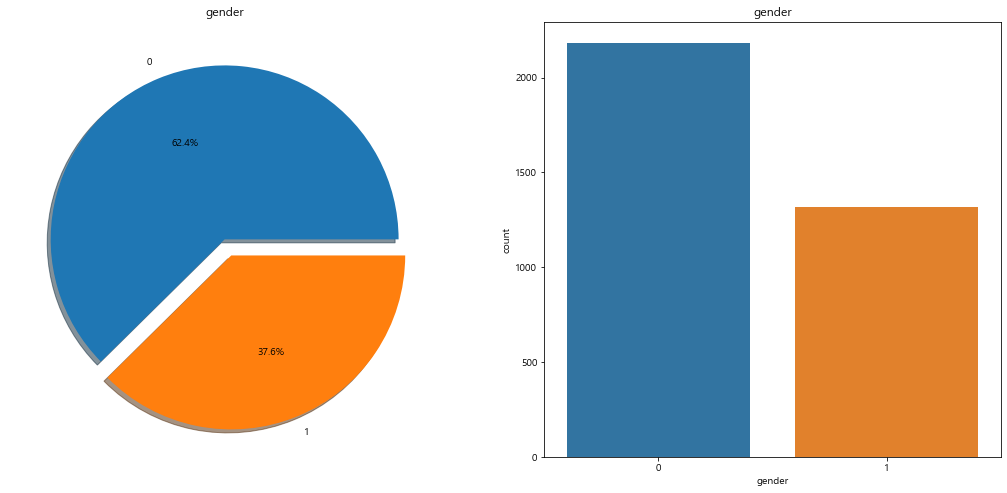

In [7]:
# 남자와 여자의 비율보기
f,ax=plt.subplots(1,2,figsize=(18,8))
y_train_check['gender'].value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_title('gender')
ax[0].set_ylabel('')
sns.countplot('gender',data=y_train_check,ax=ax[1])
ax[1].set_title('gender')
plt.show()

#### - 타겟 데이터인 'gender'의 분포 확인 : 
    ㄴ (여자[0]: 62.4%,  남자[1]: 37.6%)로 타겟 데이터가 약간 불균형한 것을 알 수 있다.

#### 2) NULL DATA Check

In [8]:
# null data값 체크하기
features.isnull().sum()

총구매액              0
구매건수              0
평균구매액             0
최대구매액             0
구매상품종류1           0
                 ..
시즌 마감 방문비율        0
상반기 구매비율          0
구매 추세             0
주구매지점재방문률         0
내점시마다 구매액의 일관성    0
Length: 67, dtype: int64

In [9]:
# null 값이 있는 feature만 확인을 위해 딕셔너리 형태로 변환
x = dict(features.isnull().sum())
x = {key: value for key, value in x.items() if value != 0}

In [10]:
# null 값이 있는 feature만 확인
x

{'환불금액': 3906,
 '환불건수': 3906,
 '화장품구매주기': 3202,
 '식료품구매액비율': 14,
 '평균식료품구매액분위': 1641,
 '스타킹구매건수': 5304,
 '주환불상품': 3906,
 '남성포함상품구매건수': 4106,
 '여성키워드상품구매건수': 2408,
 '가격선호도': 10,
 '행사상품구매수': 3219,
 '충동지수': 14,
 '만족도 떨어지는 제품 총 구입금액': 3862,
 '가성비 제품 총 구입금액': 536,
 '취미용품 구매비율': 3,
 '아동용품 구매건수': 3,
 '구매액표준편차': 532}

In [11]:
# null 값이 있는 feature들을 dataframe 형식으로 표현
features[['환불금액', '환불건수', '화장품구매주기', '식료품구매액비율', '평균식료품구매액분위', '스타킹구매건수', '주환불상품', '남성포함상품구매건수', '여성키워드상품구매건수', '가격선호도', '행사상품구매수', '충동지수', '만족도 떨어지는 제품 총 구입금액', '가성비 제품 총 구입금액', '취미용품 구매비율', '아동용품 구매건수', '구매액표준편차']].head(10)

,환불금액,환불건수,화장품구매주기,식료품구매액비율,평균식료품구매액분위,스타킹구매건수,주환불상품,남성포함상품구매건수,여성키워드상품구매건수,가격선호도,행사상품구매수,충동지수,만족도 떨어지는 제품 총 구입금액,가성비 제품 총 구입금액,취미용품 구매비율,아동용품 구매건수,구매액표준편차
0,6860000.0,3.0,46.0,0.025218,2.0,NaN,디자이너부틱,1.0,9.0,2.0,5.0,0.052632,17829000.0,62662040.0,0.056338,0.0,2.019925e+06
1,300000.0,1.0,NaN,0.000000,NaN,NaN,아웃도아,NaN,NaN,2.0,NaN,0.500000,NaN,2136000.0,0.500000,0.0,1.269186e+06
2,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,2.0,NaN,2.0,NaN,0.500000,NaN,NaN,0.000000,0.0,8.474256e+05
3,NaN,NaN,NaN,0.237317,4.0,2.0,NaN,NaN,NaN,1.0,NaN,0.055556,4654000.0,9063320.0,0.000000,2.0,9.917303e+05
4,NaN,NaN,0.0,0.000000,NaN,NaN,NaN,NaN,1.0,4.0,NaN,0.500000,NaN,2050000.0,0.000000,0.0,1.240769e+07
5,462000.0,1.0,NaN,0.000000,NaN,NaN,디자이너부틱,NaN,1.0,3.0,NaN,0.333333,9488000.0,9579000.0,0.000000,0.0,4.152244e+06
6,4582000.0,3.0,NaN,0.000000,NaN,NaN,수입ACC,NaN,1.0,2.0,NaN,0.200000,7040000.0,7040000.0,0.000000,2.0,2.546581e+06
7,29524000.0,4.0,22.0,0.033213,5.0,NaN,명품잡화,NaN,31.0,3.0,1.0,0.015873,NaN,218428430.0,0.067901,5.0,5.275328e+06
8,NaN,NaN,42.0,0.002239,2.0,1.0,NaN,1.0,8.0,4.0,2.0,0.055556,304627000.0,525002660.0,0.028037,9.0,2.042944e+07
9,NaN,NaN,NaN,0.011584,1.0,NaN,NaN,1.0,NaN,3.0,NaN,1.000000,NaN,14037850.0,0.000000,0.0,4.988112e+06


In [12]:
# 시각화를 위해 null 값이 있는 feature들을 리스트 형태로 표시
x.keys()

dict_keys(['환불금액', '환불건수', '화장품구매주기', '식료품구매액비율', '평균식료품구매액분위', '스타킹구매건수', '주환불상품', '남성포함상품구매건수', '여성키워드상품구매건수', '가격선호도', '행사상품구매수', '충동지수', '만족도 떨어지는 제품 총 구입금액', '가성비 제품 총 구입금액', '취미용품 구매비율', '아동용품 구매건수', '구매액표준편차'])

<AxesSubplot:>

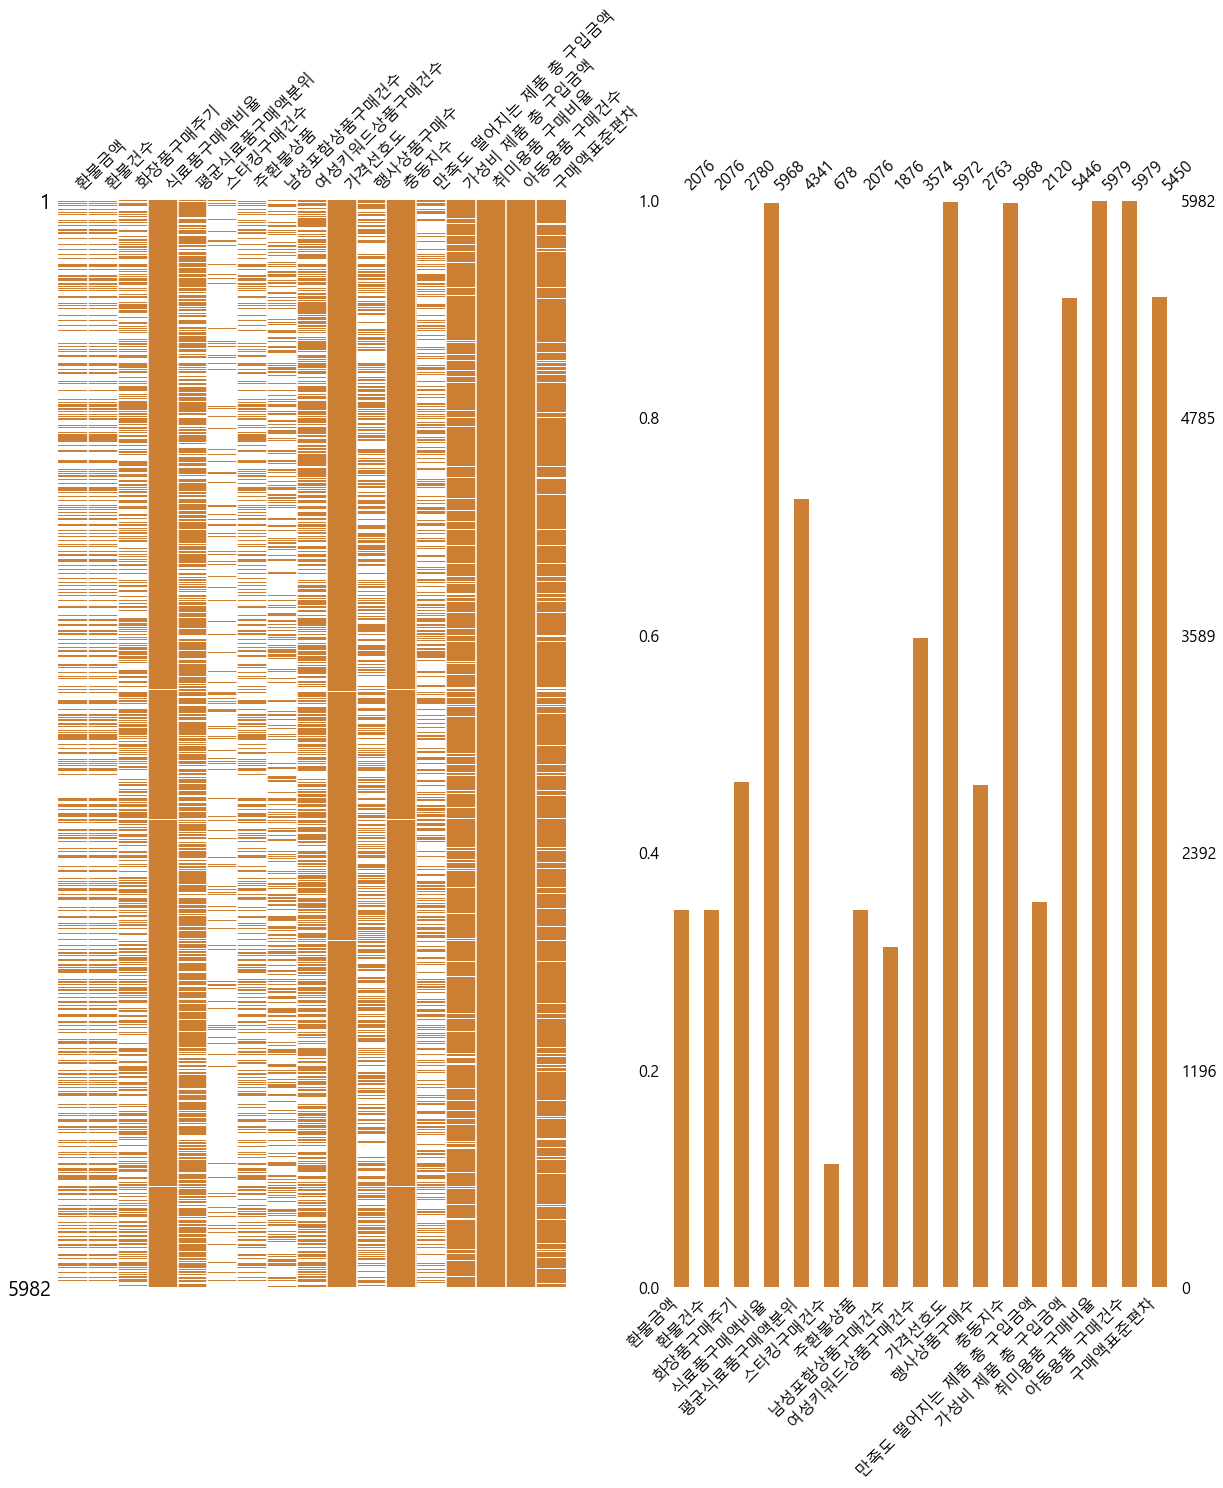

In [13]:
#null 값의 존재를 더쉽게 시각화하기

f,ax=plt.subplots(1,2,figsize=(20,20))
ax[0]=msno.matrix(df=features[['환불금액', '환불건수', '화장품구매주기', '식료품구매액비율', '평균식료품구매액분위', '스타킹구매건수', '주환불상품', '남성포함상품구매건수', '여성키워드상품구매건수', '가격선호도', '행사상품구매수', '충동지수', '만족도 떨어지는 제품 총 구입금액', '가성비 제품 총 구입금액', '취미용품 구매비율', '아동용품 구매건수', '구매액표준편차']].iloc[:, :], figsize=(8, 8), color=(0.8, 0.5, 0.2),ax=ax[0])
msno.bar(df=features[['환불금액', '환불건수', '화장품구매주기', '식료품구매액비율', '평균식료품구매액분위', '스타킹구매건수', '주환불상품', '남성포함상품구매건수', '여성키워드상품구매건수', '가격선호도', '행사상품구매수', '충동지수', '만족도 떨어지는 제품 총 구입금액', '가성비 제품 총 구입금액', '취미용품 구매비율', '아동용품 구매건수', '구매액표준편차']].iloc[:, :], figsize=(8, 8), color=(0.8, 0.5, 0.2),ax=ax[1])

 - 수치형 변수에서 '구매액표준편차'를 제외한 결측값들은 0으로 채우는 것이 좋아보인다.
 - 수치형 변수에서 '구매액표준편차'는 0이 아닌 평균값이나 중앙값으로 채우는 것이 좋아보인다.
 - 범주형 변수에서 '주환불상품'은 최빈값으로 채우는 것이 '없음'이라는 값을 새로 만들어서 채우는 것이 좋아보인다.

#### 3) Data Analysis

- 수치형 변수와 target과의 상관관계 파악

In [14]:
# target데이터와의 수치형변수와의 상관관계를 보기위해 target데이터와 features 합치기
y_train_df = y_train.reset_index().loc[:,['gender']]
all_data = pd.concat([features, y_train_df]).reset_index(drop=True)

In [15]:
# 범주형 변수와 수치형 변수를 분리
num_features = all_data.select_dtypes(exclude='object').columns.to_list()
if len(num_features) > 0: 
    all_data[num_features] = SimpleImputer(strategy='constant', fill_value=0).fit_transform(all_data[num_features])

In [16]:
# target데이터와 수치형변수의 상관관계
all_data[num_features].corr().gender.sort_values(ascending=False)

gender                1.000000e+00
구매 추세                 2.500457e-02
전체방문_중_환불방문(표준화)      2.420166e-11
화이트                  -3.929755e-02
발렌타인                 -3.995352e-02
명절식품비용               -4.081726e-02
구매 추세 기울기            -4.270843e-02
내점시마다 구매액의 일관성       -6.354235e-02
만족도 떨어지는 제품 총 구입금액   -7.855397e-02
환불금액                 -8.119072e-02
스타킹구매건수              -8.513905e-02
아동용품 구매건수            -9.704320e-02
환불건수                 -1.117226e-01
만족도 떨어지는 제품 총 구매건수   -1.129968e-01
취미용품 구매비율            -1.155983e-01
환불비율                 -1.221859e-01
남성포함상품구매건수           -1.262722e-01
행사상품구매수              -1.321740e-01
남성용품구매건수             -1.380021e-01
평균구매액                -1.531675e-01
여성용품구매건수             -1.552270e-01
가성비 제품 총 구입금액        -1.557997e-01
식료품구매액비율             -1.594616e-01
구매건수                 -1.623925e-01
여성키워드상품구매건수          -1.699941e-01
평균대비구매비중             -1.719778e-01
총구매액                 -1.719778e-01
화장품구매주기              -1.746401e-01
구매액표준편차             

In [17]:
dict(all_data[num_features].corr().gender.sort_values(ascending=False)).keys()

dict_keys(['gender', '구매 추세', '전체방문_중_환불방문(표준화)', '화이트', '발렌타인', '명절식품비용', '구매 추세 기울기', '내점시마다 구매액의 일관성', '만족도 떨어지는 제품 총 구입금액', '환불금액', '스타킹구매건수', '아동용품 구매건수', '환불건수', '만족도 떨어지는 제품 총 구매건수', '취미용품 구매비율', '환불비율', '남성포함상품구매건수', '행사상품구매수', '남성용품구매건수', '평균구매액', '여성용품구매건수', '가성비 제품 총 구입금액', '식료품구매액비율', '구매건수', '여성키워드상품구매건수', '평균대비구매비중', '총구매액', '화장품구매주기', '구매액표준편차', '최대구매액', '패션_대비_남성상품_거래율', '내점일수', '내점당구매액', '휴면일수', '시즌 마감 방문비율', '구매상품종류1', '구매주기', '충동지수', '단독상품군구매율', '의류_거래율(의류+식품+생활잡화)', '여름-구매비율', '겨울-구매비율', '봄-구매비율', '가을-구매비율', '월_재방문율', '패션_대비_여성상품_거래율', '고가상품구매율', '평균식료품구매액분위', '하루 최고 구매 건수', '저가상품구매율', '중복구매배수', '내점당구매건수', '상반기 구매비율', '베스트셀러구매비율', '요일 간 구매건수 편차', '선호방문월', '다양한 매장 방문', '가격선호도', '평일방문비율', '주구매지점재방문률'])

<AxesSubplot:>

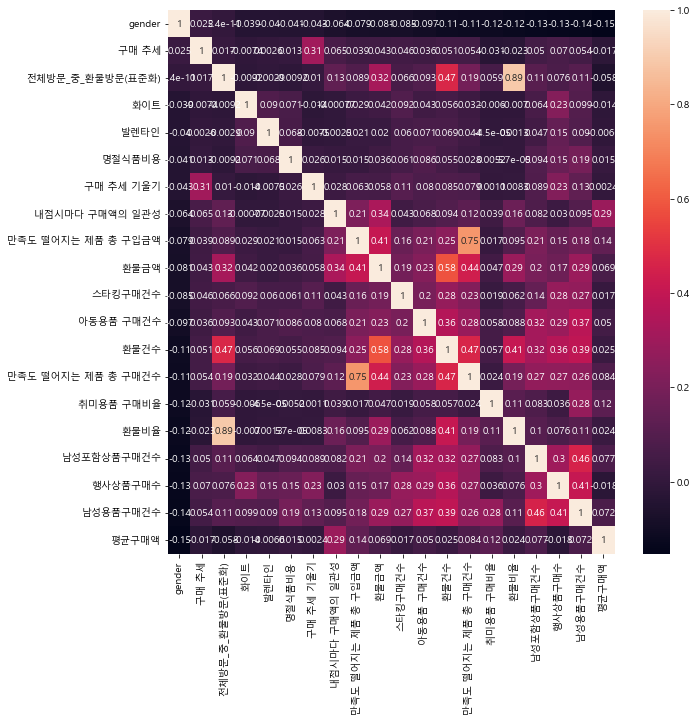

In [18]:
#데이터 상관관계
heatmap_data = all_data[['gender', '구매 추세', '전체방문_중_환불방문(표준화)', '화이트', '발렌타인', '명절식품비용', '구매 추세 기울기', '내점시마다 구매액의 일관성', '만족도 떨어지는 제품 총 구입금액', '환불금액', '스타킹구매건수', '아동용품 구매건수', '환불건수', '만족도 떨어지는 제품 총 구매건수', '취미용품 구매비율', '환불비율', '남성포함상품구매건수', '행사상품구매수', '남성용품구매건수', '평균구매액']]

plt.figure(figsize=(10,10))
all_data.head()
sns.heatmap(heatmap_data.astype(float).corr(), annot=True)

<AxesSubplot:>

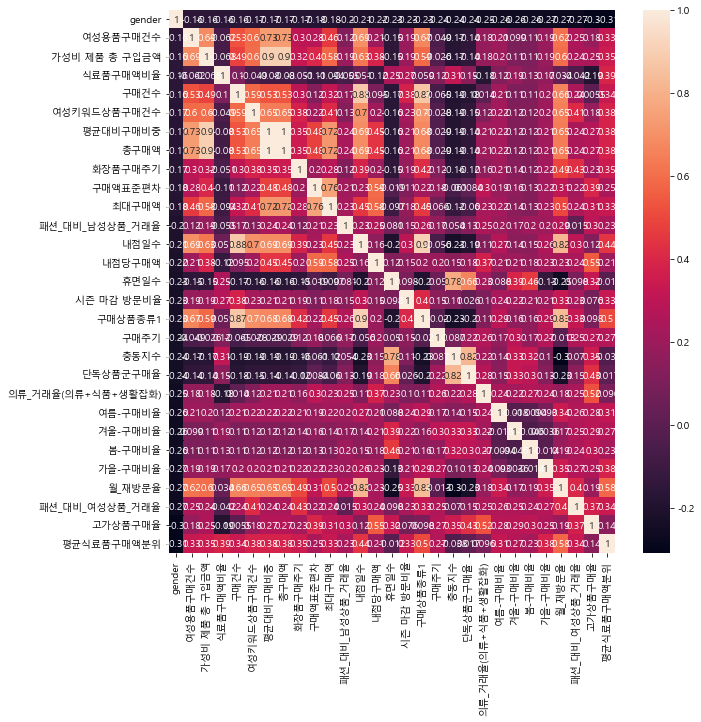

In [19]:
#데이터 상관관계
heatmap_data_2 = all_data[['gender', '여성용품구매건수', '가성비 제품 총 구입금액', '식료품구매액비율', '구매건수', '여성키워드상품구매건수', '평균대비구매비중', '총구매액', '화장품구매주기', '구매액표준편차', '최대구매액', '패션_대비_남성상품_거래율', '내점일수', '내점당구매액', '휴면일수', '시즌 마감 방문비율', '구매상품종류1', '구매주기', '충동지수', '단독상품군구매율', '의류_거래율(의류+식품+생활잡화)', '여름-구매비율', '겨울-구매비율', '봄-구매비율', '가을-구매비율', '월_재방문율', '패션_대비_여성상품_거래율', '고가상품구매율', '평균식료품구매액분위']]
plt.figure(figsize=(10,10))
all_data.head()
sns.heatmap(heatmap_data_2.astype(float).corr(), annot=True)

<AxesSubplot:>

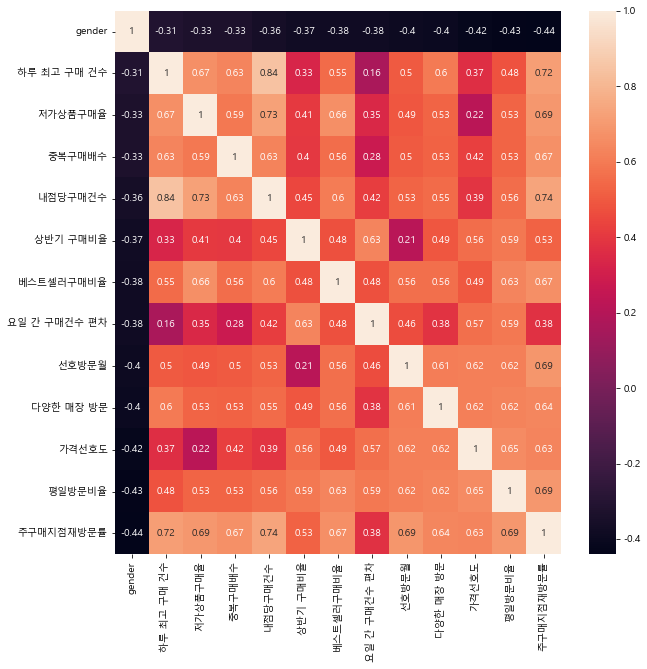

In [20]:
#데이터 상관관계
heatmap_data_3 = all_data[['gender', '하루 최고 구매 건수', '저가상품구매율', '중복구매배수', '내점당구매건수', '상반기 구매비율', '베스트셀러구매비율', '요일 간 구매건수 편차', '선호방문월', '다양한 매장 방문', '가격선호도', '평일방문비율', '주구매지점재방문률']]
plt.figure(figsize=(10,10))
all_data.head()
sns.heatmap(heatmap_data_3.astype(float).corr(), annot=True)

<AxesSubplot:title={'center':'Feature-correlation (pearson)'}>

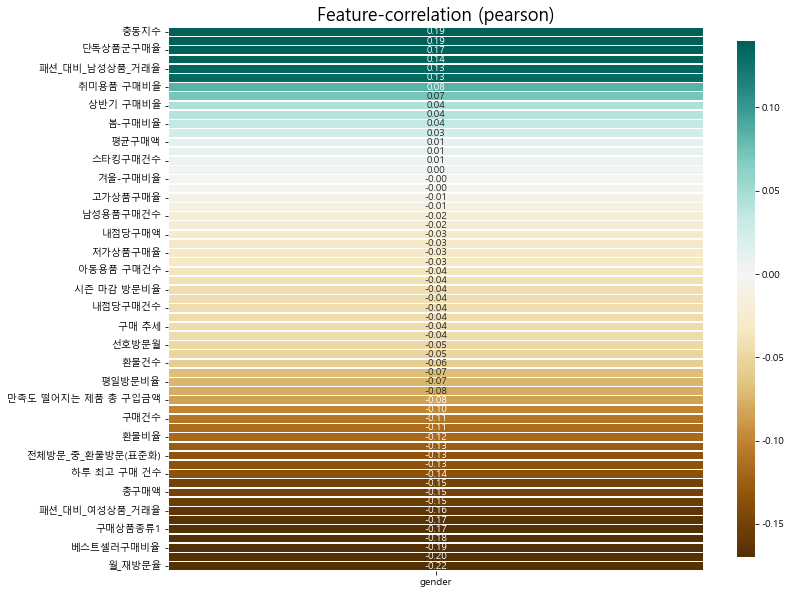

In [21]:
# 속성별 예측 능력 파악 
# klib 사용
klib.corr_plot(pd.concat([train, y_train], axis=1), target='gender')

#### 4) Pandas Profiling

- 판다스 프로파일링은 간단한 코드로 여러 분석 통계량을 확인할 수 이는 기능을 제공함.
- 탐색적 데이터 분석에 드는 시간을 절약하기 위해 몇 줄의 코드로 여러 분석 통계량을 확인할 수 이는 기능을 제공하는 하는 데 이를 프로파일링(profiling)이라 합니다.

In [22]:
# !pip install pandas-profiling
# 주피터에서 설치했는데 실행이 안되면 anaconda prompt 들어가서
# ⤷ "pip install -U pandas-profiling" 설치

In [23]:
# from pandas_profiling import ProfileReport
# profile = ProfileReport(features, title="Pandas Profiling Report", explorative=True)
# profile

**TO DO**: 아래와 같은 Automating EDA tool을 사용하여 Raw Data의 구조와 특징을 파악한다.
- `DataPrep`, `Pandas Profiling`, `SweetViz`, `AutoViz`

### 3. Data Cleansing & Feature Engineering

In [24]:
# 범주형 변수와 수치형 변수를 분리

cat_features = features.select_dtypes(include=['object']).columns.to_list()
num_features = features.select_dtypes(exclude='object').columns.to_list()
#num_features = [c for c in features.columns.tolist() if c not in cat_features]  

### 1) Impute Missing Values

#### 1) EDA 분석한 결과로 결측값 채우기

- 수치형 변수에서 '구매액표준편차'를 제외한 결측값들은 0으로 채우는 것이 좋아보인다.
- 수치형 변수에서 '구매액표준편차'는 0이 아닌 평균값이나 중앙값으로 채우는 것이 좋아보인다.
- 범주형 변수에서 '주환불상품'은 최빈값으로 채우는 것이 '없음'이라는 값을 새로 만들어서 채우는 것이 좋아보인다.
- 범주형 변수에서 '발렌타인', '화이트', '다양한 매장 방문'은 0으로 채우는 것이 좋아보인다.

In [25]:
# 수치형 변수에서 '발렌타인', '화이트', '다양한 매장 방문'은 범주형 변수로 처리
cat_features.extend(['발렌타인','화이트','다양한 매장 방문'])
num_features.remove('발렌타인')
num_features.remove('화이트')
num_features.remove('다양한 매장 방문')

In [26]:
# 결측값 처리: 수치형
# 해당 데이터 기준, '구매액표준편차'의 결측값을 중앙값, 평균으로 처리하는 방법이 0으로 처리하는 방법보다 조금 더 높은 성능이 도출됨.
# 다만, 그 성능의 차이가 미미하고 코드 일반화를 위해 0으로 처리함.

"""
# '구매액표준편차' 중앙값 대체
if len(['구매액표준편차']) > 0:
    train[['구매액표준편차']] = SimpleImputer(strategy="median").fit_transform(train[['구매액표준편차']])
if len(['구매액표준편차']) > 0:
    test[['구매액표준편차']] = SimpleImputer(strategy="median").fit_transform(test[['구매액표준편차']])
---------------------________________
'구매액표준편차' 평균값 대체
if len(['구매액표준편차']) > 0:
    train[['구매액표준편차']] = SimpleImputer(strategy="mean").fit_transform(train[['구매액표준편차']])
if len(['구매액표준편차']) > 0:
    test[['구매액표준편차']] = SimpleImputer(strategy="mean").fit_transform(test[['구매액표준편차']])
"""
if len(num_features) > 0: 
    train[num_features] = SimpleImputer(strategy='constant', fill_value=0).fit_transform(train[num_features])
if len(num_features) > 0: 
    test[num_features] = SimpleImputer(strategy='constant', fill_value=0).fit_transform(test[num_features])

In [27]:
# 결측값 처리: 범주형
"""
'주환불상품' 결측값 '없음'으로 대체
if len(cat_features) > 0: 
    train[cat_features] = SimpleImputer(strategy='constant', fill_value='없음').fit_transform(train[cat_features])
if len(cat_features) > 0: 
    test[cat_features] = SimpleImputer(strategy='constant', fill_value='없음').fit_transform(test[cat_features])
"""
    
if len(cat_features) > 0: 
    train[cat_features] = SimpleImputer(strategy="most_frequent").fit_transform(train[cat_features])
if len(cat_features) > 0: 
    test[cat_features] = SimpleImputer(strategy="most_frequent").fit_transform(test[cat_features])

#### 2) KNN 방식
- 바로 각 데이터에 대한 novelty score를 k개의 근접 이웃까지 거리를 이용하여 계산하는 방법


In [28]:
"""
np_imputed = fast_knn(train[num_features].values, k = 5)
train[num_features] = pd.DataFrame(np_imputed, columns = num_features)

np_imputed = fast_knn(test[num_features].values, k = 5)
test[num_features] = pd.DataFrame(np_imputed, columns = num_features)
"""

'\nnp_imputed = fast_knn(train[num_features].values, k = 5)\ntrain[num_features] = pd.DataFrame(np_imputed, columns = num_features)\n\nnp_imputed = fast_knn(test[num_features].values, k = 5)\ntest[num_features] = pd.DataFrame(np_imputed, columns = num_features)\n'

#### 3) 그외 방식
1) 아무것도 하지 않기 : 모델이 결측값을 알아서 처리하도록 함.  
2) 결측값 데이터 제거  
3) mean/ median : 쉽고 빠르나, 다른 feature 간의 상관관계가 고려되지 않음.  
4) most frequent, zero, constant(지정값)  
5) KNN : 근접한 데이터 찾기  
6) Mice : 결측값을 여러번 채우는 방식  

### 2) Deal with Outliers

#### 1) 가장 단순한 방법 상하위 5%값 대체

In [29]:
# 상하위 5% 데이터를 clip을 사용하여 상위 5%이상인 이상치는 상위 5%값으로 대체 하위 5%이하인 이상치는 하위 5%값으로 대체
"""
train[num_features] = train[num_features].apply(lambda x: x.clip(x.quantile(.05), x.quantile(.95)), axis=0)
test[num_features] = test[num_features].apply(lambda x: x.clip(x.quantile(.05), x.quantile(.95)), axis=0)
"""

'\ntrain[num_features] = train[num_features].apply(lambda x: x.clip(x.quantile(.05), x.quantile(.95)), axis=0)\ntest[num_features] = test[num_features].apply(lambda x: x.clip(x.quantile(.05), x.quantile(.95)), axis=0)\n'

#### 2) IQR 방식
- 데이터 내에서 이상값을 탐지하는 강력한 방법 중 하나로 탐색적 데이터 분석(EDA)의 선구자인 John Tukey가 개발한 이상치 검출 IQR (사 분위 범위) 방법이 있다. 역사가 오래된 전통적인 방법이다.
- IQR이란, Interquartile range의 약자로써 Q3 - Q1를 의미한다.  
   ㄴQ3 - Q1: 사분위수의 상위 75% 지점의 값과 하위 25% 지점의 값 차이
- Q1에서 1.5 * IQR을 한 값을 빼준 값을 최소 제한선, Q3에서 1.5 * IQR을 더해준 값을 최대 제한선으로 둔다.

In [30]:
# IQR방식을 이용, 데이터가 크지 않으므로 drop보다는 clip을 사용
train[num_features] = train[num_features].apply(lambda x: x.clip(x.quantile(.25) - ((x.quantile(.75) - x.quantile(.25))*1.5), x.quantile(.75) + ((x.quantile(.75) - x.quantile(.25))*1.5)), axis=0)
test[num_features] = test[num_features].apply(lambda x: x.clip(x.quantile(.25) - ((x.quantile(.75) - x.quantile(.25))*1.5), x.quantile(.75) + ((x.quantile(.75) - x.quantile(.25))*1.5)), axis=0)

### 3) pycaret을 활용한 최적의 이상치, 결측치 combination

In [31]:
# 이상치 처리 방식 2가지(상하위 5%값 대체, IQR 방식) 사용
# 수치형 변수에서 '구매액 표준편차'를 0, mean값, median 값
# 범주형 변수에서 '주환불상품'을 없음, most_frequent로 채운 값
# 6가지 (0,없음), (0,most_frequent), (mean,없음), (mean,most_frequent), (median,없음), (median,most_frequent)를 pycaret으로 돌려보기

In [32]:
"""
이상치 처리 IQR방식 사용
('구매액표준편차', '주환불상품') : (AUC 최상위 스코어, AUC 최소 스코어) 상위 6개모델 기준
(0,없음) :               0.7474 | 0.7178  2등
(0,most_frequent) :      0.7454 | 0.7177  6등
(mean,없음) :            0.7482 | 0.7180  1등
(mean,most_frequent) :   0.7459 | 0.7179  4등
(median, 없음) :         0.7469 | 0.7181  3등
(median,most_freuqent) : 0.7454 | 0.7181  5등

이상치 처리 상하위 5%값 대체 방식 사용
('구매액표준편차', '주환불상품') : (AUC 최상위 스코어, AUC 최소 스코어) 상위 6개모델 기준
(0,없음) :               0.7481 | 0.7139  1등
(0,most_frequent) :      0.7456 | 0.7140  3등
(mean,없음) :            0.7454 | 0.7135  4등
(mean,most_frequent) :   0.7472 | 0.7136  2등
(median, 없음) :         0.7452 | 0.7136  5등
(median,most_freuqent) : 0.7451 | 0.7136  6등
결론 : IQR방식 (mean,없음) 조합을 사용하는 것이 성능이 좋다
"""

"\n이상치 처리 IQR방식 사용\n('구매액표준편차', '주환불상품') : (AUC 최상위 스코어, AUC 최소 스코어) 상위 6개모델 기준\n(0,없음) :               0.7474 | 0.7178  2등\n(0,most_frequent) :      0.7454 | 0.7177  6등\n(mean,없음) :            0.7482 | 0.7180  1등\n(mean,most_frequent) :   0.7459 | 0.7179  4등\n(median, 없음) :         0.7469 | 0.7181  3등\n(median,most_freuqent) : 0.7454 | 0.7181  5등\n\n이상치 처리 상하위 5%값 대체 방식 사용\n('구매액표준편차', '주환불상품') : (AUC 최상위 스코어, AUC 최소 스코어) 상위 6개모델 기준\n(0,없음) :               0.7481 | 0.7139  1등\n(0,most_frequent) :      0.7456 | 0.7140  3등\n(mean,없음) :            0.7454 | 0.7135  4등\n(mean,most_frequent) :   0.7472 | 0.7136  2등\n(median, 없음) :         0.7452 | 0.7136  5등\n(median,most_freuqent) : 0.7451 | 0.7136  6등\n결론 : IQR방식 (mean,없음) 조합을 사용하는 것이 성능이 좋다\n"

In [33]:
# pycaret_best = setup(data = pd.concat([train, y_train], axis = 1), target = "gender", session_id = 6426)

In [34]:
# compare_models(sort = 'AUC')

- 이상치 처리를 IQR 방식으로 할때는 결측치 처리를 (median,most_freuqent) 조합이 좋다.
- 이상치 처리를 상하위 5% 대체 방식으로 할 때는 (mean,없음) 조합이 좋다.
- 최고 조합은 상하위 5% 대체 방식 (mean, 없음)이지만 6개모델 auc 최소값이 IQR처리 방식일때가 눈에띄게 높다.
- 결론 : IQR 방식 채택 - 그중에서 가장 성능이 좋았던 (median,most_freuqent) 조합 사용

### 3) Transform Features

In [35]:
# 6가지 종류의 Scaler를 사용
'''
StandardScaler()
MinMaxScaler()
PowerTransformer()
Normalizer()
RobustScaler()
MaxAbsScaler()
'''

'\nStandardScaler()\nMinMaxScaler()\nPowerTransformer()\nNormalizer()\nRobustScaler()\nMaxAbsScaler()\n'

In [36]:
# 모델을 돌리기위하여 train, test 데이터 분할
X_strain,X_stest,y_strain,y_stest = train_test_split(train[num_features],y_train, test_size=0.3, random_state = 0)

In [37]:
# all_estimator에 scaler를 포함시켜 좋은 성능을 내는 scaler 찾기
all_Algorithm = all_estimators(type_filter = 'regressor')
scaler_list = [StandardScaler(),MinMaxScaler(),PowerTransformer(),Normalizer(),RobustScaler(),MaxAbsScaler()]
best_roc_auc=[]
for scaler in scaler_list:
    scaler.fit(X_strain)
    X_strain = scaler.transform(X_strain)
    X_stest = scaler.transform(X_stest)
    for (name,algorithm) in all_Algorithm:
        try:
            model = algorithm()
            model.fit(X_strain,y_strain)
            y_pred = model.predict(X_stest)
            roc_auc = roc_auc_score(y_stest,y_pred)
            best_roc_auc.append(roc_auc)
            print(name , "\'s ROC_AUC : ", roc_auc)
            print("-----------------------------------------------")
            print(roc_auc,max(best_roc_auc))
            if max(best_roc_auc)<=roc_auc:
                final_roc_auc = roc_auc
                final_roc_auc_model = name
                final_roc_auc_scaler = scaler
        except:
            continue

ARDRegression 's ROC_AUC :  0.741271661819221
-----------------------------------------------
0.741271661819221 0.741271661819221
AdaBoostRegressor 's ROC_AUC :  0.7163148190917596
-----------------------------------------------
0.7163148190917596 0.741271661819221
BaggingRegressor 's ROC_AUC :  0.7117015904580346
-----------------------------------------------
0.7117015904580346 0.741271661819221
BayesianRidge 's ROC_AUC :  0.7441801292565206
-----------------------------------------------
0.7441801292565206 0.7441801292565206
CCA 's ROC_AUC :  0.7410054763740845
-----------------------------------------------
0.7410054763740845 0.7441801292565206
DecisionTreeRegressor 's ROC_AUC :  0.5816504280496827
-----------------------------------------------
0.5816504280496827 0.7441801292565206
DummyRegressor 's ROC_AUC :  0.5
-----------------------------------------------
0.5 0.7441801292565206
ElasticNet 's ROC_AUC :  0.5
-----------------------------------------------
0.5 0.744180129256520

LassoCV 's ROC_AUC :  0.7413597378856264
-----------------------------------------------
0.7413597378856264 0.7442114451912425
LassoLars 's ROC_AUC :  0.5
-----------------------------------------------
0.5 0.7442114451912425
LassoLarsCV 's ROC_AUC :  0.7410837662108893
-----------------------------------------------
0.7410837662108893 0.7442114451912425
LassoLarsIC 's ROC_AUC :  0.7397880694117693
-----------------------------------------------
0.7397880694117693 0.7442114451912425
LinearRegression 's ROC_AUC :  0.7410054763740845
-----------------------------------------------
0.7410054763740845 0.7442114451912425
LinearSVR 's ROC_AUC :  0.7202116957187203
-----------------------------------------------
0.7202116957187203 0.7442114451912425
MLPRegressor 's ROC_AUC :  0.6879680264306489
-----------------------------------------------
0.6879680264306489 0.7442114451912425
NuSVR 's ROC_AUC :  0.7029566156869347
-----------------------------------------------
0.7029566156869347 0.7442114

TheilSenRegressor 's ROC_AUC :  0.5366181139195415
-----------------------------------------------
0.5366181139195415 0.7453114173983505
TransformedTargetRegressor 's ROC_AUC :  0.7395688578687157
-----------------------------------------------
0.7395688578687157 0.7453114173983505
TweedieRegressor 's ROC_AUC :  0.7296651935129042
-----------------------------------------------
0.7296651935129042 0.7453114173983505
ARDRegression 's ROC_AUC :  0.7427630832103531
-----------------------------------------------
0.7427630832103531 0.7453114173983505
AdaBoostRegressor 's ROC_AUC :  0.7024262020425819
-----------------------------------------------
0.7024262020425819 0.7453114173983505
BaggingRegressor 's ROC_AUC :  0.6964017991004497
-----------------------------------------------
0.6964017991004497 0.7453114173983505
BayesianRidge 's ROC_AUC :  0.7404926779430128
-----------------------------------------------
0.7404926779430128 0.7453114173983505
CCA 's ROC_AUC :  0.7394866535400707
-----

KernelRidge 's ROC_AUC :  0.7310235221814679
-----------------------------------------------
0.7310235221814679 0.7453114173983505
Lars 's ROC_AUC :  0.5840539260395912
-----------------------------------------------
0.5840539260395912 0.7453114173983505
LarsCV 's ROC_AUC :  0.6484551457952487
-----------------------------------------------
0.6484551457952487 0.7453114173983505
Lasso 's ROC_AUC :  0.5
-----------------------------------------------
0.5 0.7453114173983505
LassoCV 's ROC_AUC :  0.7424851542896959
-----------------------------------------------
0.7424851542896959 0.7453114173983505
LassoLars 's ROC_AUC :  0.5
-----------------------------------------------
0.5 0.7453114173983505
LassoLarsCV 's ROC_AUC :  0.7426299904877848
-----------------------------------------------
0.7426299904877848 0.7453114173983505
LassoLarsIC 's ROC_AUC :  0.7427826556695543
-----------------------------------------------
0.7427826556695543 0.7453114173983505
LinearRegression 's ROC_AUC :  0.739

SVR 's ROC_AUC :  0.7306399019811243
-----------------------------------------------
0.7306399019811243 0.7453114173983505
TheilSenRegressor 's ROC_AUC :  0.5071106744277992
-----------------------------------------------
0.5071106744277992 0.7453114173983505
TransformedTargetRegressor 's ROC_AUC :  0.7394866535400707
-----------------------------------------------
0.7394866535400707 0.7453114173983505
TweedieRegressor 's ROC_AUC :  0.6902306027143086
-----------------------------------------------
0.6902306027143086 0.7453114173983505


In [38]:
print("Best ROC_AUC & model & scaler: ",final_roc_auc," & ",final_roc_auc_model, "&",scaler)

Best ROC_AUC & model & scaler:  0.7453114173983505  &  LassoCV & MaxAbsScaler()


In [39]:
def Scaler(model):
    scaler_value = []
    for scaler in scaler_list:
        X_train_sc = scaler.fit_transform(X_strain)
        X_test_sc = scaler.transform(X_stest)

        model.fit(X_train_sc, y_strain)
        pred = model.predict(X_test_sc)
        pred_proba = model.predict_proba(X_test_sc)[:, 1]
        roc_score = roc_auc_score(y_stest, pred_proba)
        print(str(scaler).split('(')[0],':', roc_score)

        
svm = SVC(random_state = 0, probability=True)
mlp = MLPClassifier(random_state=0)
gb = GradientBoostingClassifier(random_state=0)
cat = AdaBoostClassifier(random_state=0)
knn = KNeighborsClassifier()

model_lst = [svm, mlp, gb, cat, knn]

for model in model_lst:
    print(str(model).split('(')[0],"'s Scaler별 성능")    
    print('-----------------------------------------')
    Scaler(model)
    print()

SVC 's Scaler별 성능
-----------------------------------------
StandardScaler : 0.7400620838405862
MinMaxScaler : 0.741514360313316
PowerTransformer : 0.7387115841557028
Normalizer : 0.7382535886103946
RobustScaler : 0.7408528111923152
MaxAbsScaler : 0.7400307679058643

MLPClassifier 's Scaler별 성능
-----------------------------------------
StandardScaler : 0.7057907077792696
MinMaxScaler : 0.7410798517190491
PowerTransformer : 0.6978012299333362
Normalizer : 0.7407197184697467
RobustScaler : 0.7126019235812903
MaxAbsScaler : 0.719041262658488

GradientBoostingClassifier 's Scaler별 성능
-----------------------------------------
StandardScaler : 0.7366232027589338
MinMaxScaler : 0.7366232027589338
PowerTransformer : 0.7364587941016437
Normalizer : 0.7294205377728891
RobustScaler : 0.7366232027589338
MaxAbsScaler : 0.7366232027589338

AdaBoostClassifier 's Scaler별 성능
-----------------------------------------
StandardScaler : 0.7279408598572776
MinMaxScaler : 0.7279408598572776
PowerTransformer 

In [40]:
st_scaler = StandardScaler()
mi_scaler = MinMaxScaler()
po_scaler = PowerTransformer()
no_scaler = Normalizer()
ro_scaler = RobustScaler()
ma_scaler = MaxAbsScaler()

In [41]:
train[num_features] = po_scaler.fit_transform(train[num_features])
test[num_features] = po_scaler.transform(test[num_features])

### 4) Encode Categorical Variables

In [42]:
# <mean-encoding>
encoder_obj = ce.TargetEncoder
encoder = encoder_obj(cols = cat_features)
train_enc = encoder.fit_transform(train, y_train)
train = train_enc
# test 데이터 인코딩
test_enc = encoder.transform(test)
test = test_enc

In [43]:
# <binary encoding>
"""
features = pd.concat([train, test]).reset_index(drop=True)
encoder_obj = ce.BinaryEncoder(cols = cat_features, drop_invariant = True)
enc = encoder_obj.fit_transform(features[cat_features])
features = pd.concat([features, enc], axis = 1)

features = pd.concat([pd.concat([train_id, test_id]).reset_index(drop=True), features], axis=1)
train = features.query('cust_id in @train_id').drop('cust_id', axis=1)
train.drop(cat_features, axis = 1)

test = features.query('cust_id in @test_id').drop('cust_id', axis=1)
test.drop(cat_features, axis = 1)
"""

"\nfeatures = pd.concat([train, test]).reset_index(drop=True)\nencoder_obj = ce.BinaryEncoder(cols = cat_features, drop_invariant = True)\nenc = encoder_obj.fit_transform(features[cat_features])\nfeatures = pd.concat([features, enc], axis = 1)\n\nfeatures = pd.concat([pd.concat([train_id, test_id]).reset_index(drop=True), features], axis=1)\ntrain = features.query('cust_id in @train_id').drop('cust_id', axis=1)\ntrain.drop(cat_features, axis = 1)\n\ntest = features.query('cust_id in @test_id').drop('cust_id', axis=1)\ntest.drop(cat_features, axis = 1)\n"

In [44]:
# <label encoding>
# train
"""
if len(cat_features) > 0:
    train = pd.concat([train[num_features], pd.concat([pd.Series(LabelEncoder().fit_transform(train[feature]), name = feature) for feature in cat_features], axis = 1)], axis=1)
else:
    train = train[num_features]

# test
if len(cat_features) > 0:
    test = pd.concat([test[num_features], pd.concat([pd.Series(LabelEncoder().fit_transform(test[feature]), name = feature) for feature in cat_features], axis = 1)], axis=1)
else:
    test = test[num_features]
"""

'\nif len(cat_features) > 0:\n    train = pd.concat([train[num_features], pd.concat([pd.Series(LabelEncoder().fit_transform(train[feature]), name = feature) for feature in cat_features], axis = 1)], axis=1)\nelse:\n    train = train[num_features]\n\n# test\nif len(cat_features) > 0:\n    test = pd.concat([test[num_features], pd.concat([pd.Series(LabelEncoder().fit_transform(test[feature]), name = feature) for feature in cat_features], axis = 1)], axis=1)\nelse:\n    test = test[num_features]\n'

In [45]:
# <one-hot-encoding>
"""
features = pd.concat([train, test]).reset_index(drop=True)

if len(cat_features) > 0:
    features = pd.concat([features[num_features], pd.get_dummies(features[cat_features])], axis=1)
else:
    features = features[num_features]

features

features = pd.concat([pd.concat([train_id, test_id]).reset_index(drop=True), features], axis=1)
train = features.query('cust_id in @train_id').drop('cust_id', axis=1)
test = features.query('cust_id in @test_id').drop('cust_id', axis=1)
"""

"\nfeatures = pd.concat([train, test]).reset_index(drop=True)\n\nif len(cat_features) > 0:\n    features = pd.concat([features[num_features], pd.get_dummies(features[cat_features])], axis=1)\nelse:\n    features = features[num_features]\n\nfeatures\n\nfeatures = pd.concat([pd.concat([train_id, test_id]).reset_index(drop=True), features], axis=1)\ntrain = features.query('cust_id in @train_id').drop('cust_id', axis=1)\ntest = features.query('cust_id in @test_id').drop('cust_id', axis=1)\n"

### 5) Select Features

In [46]:
train_data = train.copy()
test_data = test.copy()


(90, 0.7610233135021891)
(3500, 67)


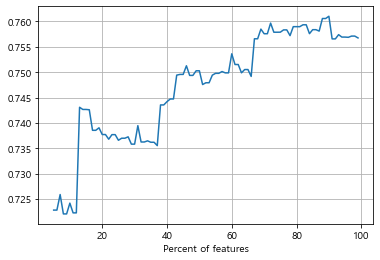

In [47]:
#GradientBoostingClassifier
model = GradientBoostingClassifier(random_state=0)

# 각 특성과 타깃(class) 사이에 유의한 통계적 관계가 있는지 계산하여 특성을 선택하는 방법 
cv_scores = []
for p in tqdm_notebook(range(5,100,1)): # 퍼센트별로 스코어를 냄- > 성능이 잘나오는 지점
    X_new = SelectPercentile(percentile=p).fit_transform(train_data, y_train)    
    cv_score = cross_val_score(model, X_new, y_train, scoring='roc_auc', cv=5).mean()
    cv_scores.append((p,cv_score))

# Print the best percentile
best_score = cv_scores[np.argmax([score for _, score in cv_scores])]
print(best_score)

# Plot the performance change with p
plt.plot([k for k, _ in cv_scores], [score for _, score in cv_scores])
plt.xlabel('Percent of features')
plt.grid()

# 과적합을 피하기 위해 최적의 p값 주변의 값을 선택하는게 더 나은 결과를 얻을 수 있다. 
fs = SelectPercentile(percentile=best_score[0]).fit(train_data, y_train)
ca_train_data = fs.transform(train_data)
ca_test_data = fs.transform(test_data)

print(train_data.shape)

In [48]:
train = train[train.iloc[:,:].columns[fs.get_support()].tolist()]
test= test[test.iloc[:,:].columns[fs.get_support()].tolist()]

### 4. Model Tuning (Hyperparameter Optimization)

In [49]:
# 학습데이터 70%, 평가데이터 30%로 데이터 분할
X_train, X_dev, y_train, y_dev = train_test_split(train, y_train, test_size=0.3, random_state=0)

In [50]:
clfs_tuned = []

In [51]:
def rf_objective(trial):
       
    rf_n_estimators = trial.suggest_int("n_estimators", 100, 1500, step=50)
    rf_max_depth = trial.suggest_int("max_depth", 1, 32, log=True)
    rf_min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 32, log = True)
    rf_criterion = trial.suggest_categorical("criterion", ["gini", "entropy"])

    classifier_obj = ensemble.RandomForestClassifier(n_estimators=rf_n_estimators,
                                                     max_depth=rf_max_depth,
                                                     min_samples_leaf=rf_min_samples_leaf,
                                                     criterion=rf_criterion,
                                                     n_jobs=-1,
                                                     random_state=0)

    score = model_selection.cross_val_score(classifier_obj,X_train, y_train, cv=5, n_jobs=-1, scoring = 'roc_auc')
    roc_auc = score.mean()
    return roc_auc


rf_study = optuna.create_study(direction="maximize")
rf_study.optimize(rf_objective, n_trials=50)
print(rf_study.best_trial)

[I 2022-05-10 22:55:05,021] A new study created in memory with name: no-name-9cdbd5fd-ed2e-447d-9d17-03fcb22b8bee
[I 2022-05-10 22:55:16,624] Trial 0 finished with value: 0.7005403964382756 and parameters: {'n_estimators': 1250, 'max_depth': 1, 'min_samples_leaf': 8, 'criterion': 'entropy'}. Best is trial 0 with value: 0.7005403964382756.
[I 2022-05-10 22:55:26,162] Trial 1 finished with value: 0.7438760570604149 and parameters: {'n_estimators': 600, 'max_depth': 30, 'min_samples_leaf': 1, 'criterion': 'gini'}. Best is trial 1 with value: 0.7438760570604149.
[I 2022-05-10 22:55:31,180] Trial 2 finished with value: 0.7009022484504018 and parameters: {'n_estimators': 950, 'max_depth': 1, 'min_samples_leaf': 6, 'criterion': 'gini'}. Best is trial 1 with value: 0.7438760570604149.
[I 2022-05-10 22:55:32,071] Trial 3 finished with value: 0.7387367587377933 and parameters: {'n_estimators': 100, 'max_depth': 4, 'min_samples_leaf': 32, 'criterion': 'gini'}. Best is trial 1 with value: 0.743876

[I 2022-05-10 23:01:43,471] Trial 34 finished with value: 0.7531288105840446 and parameters: {'n_estimators': 850, 'max_depth': 9, 'min_samples_leaf': 2, 'criterion': 'gini'}. Best is trial 29 with value: 0.7543114278470691.
[I 2022-05-10 23:01:48,620] Trial 35 finished with value: 0.7009022484504018 and parameters: {'n_estimators': 950, 'max_depth': 1, 'min_samples_leaf': 6, 'criterion': 'gini'}. Best is trial 29 with value: 0.7543114278470691.
[I 2022-05-10 23:01:57,440] Trial 36 finished with value: 0.7526078316909889 and parameters: {'n_estimators': 550, 'max_depth': 12, 'min_samples_leaf': 3, 'criterion': 'entropy'}. Best is trial 29 with value: 0.7543114278470691.
[I 2022-05-10 23:01:58,412] Trial 37 finished with value: 0.733444004323782 and parameters: {'n_estimators': 100, 'max_depth': 3, 'min_samples_leaf': 4, 'criterion': 'entropy'}. Best is trial 29 with value: 0.7543114278470691.
[I 2022-05-10 23:02:09,459] Trial 38 finished with value: 0.7500641275552703 and parameters: {

FrozenTrial(number=29, values=[0.7543114278470691], datetime_start=datetime.datetime(2022, 5, 10, 22, 59, 50, 902690), datetime_complete=datetime.datetime(2022, 5, 10, 23, 0, 10, 559461), params={'n_estimators': 1250, 'max_depth': 11, 'min_samples_leaf': 2, 'criterion': 'entropy'}, distributions={'n_estimators': IntUniformDistribution(high=1500, low=100, step=50), 'max_depth': IntLogUniformDistribution(high=32, low=1, step=1), 'min_samples_leaf': IntLogUniformDistribution(high=32, low=1, step=1), 'criterion': CategoricalDistribution(choices=('gini', 'entropy'))}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=29, state=TrialState.COMPLETE, value=None)


In [52]:
def lr_objective(trial):
    
    lr_solver = trial.suggest_categorical('solver', ['newton-cg', 'lbfgs','saga','sag'])
    lr_penalty = trial.suggest_categorical('penalty', ['l2', 'none'])
    lr_C = trial.suggest_float("C", 0.01, 15)
    lr_max_iter = trial.suggest_int('max_iter', 50, 2000)
    lr_tol = trial.suggest_float('tol', 1e-4, 1)
    
    regression_obj = LogisticRegression(solver = lr_solver,
                                        penalty = lr_penalty,
                                        C = lr_C,
                                        n_jobs = -1,
                                        random_state = 0,
                                        max_iter = lr_max_iter,
                                        tol = lr_tol)
    
    score = model_selection.cross_val_score(regression_obj, X_train, y_train, cv = 5, n_jobs = -1, scoring = 'roc_auc')
    roc_auc = score.mean()
    return roc_auc

lr_study = optuna.create_study(direction = 'maximize')
lr_study.optimize(lr_objective, n_trials=50)
print(lr_study.best_trial)

[I 2022-05-10 23:03:48,521] A new study created in memory with name: no-name-cb5a3ed2-9891-44ba-93fc-92a92b1df9c2
[I 2022-05-10 23:03:48,812] Trial 0 finished with value: 0.765580128371371 and parameters: {'solver': 'lbfgs', 'penalty': 'l2', 'C': 7.128781236743199, 'max_iter': 63, 'tol': 0.2890646853402649}. Best is trial 0 with value: 0.765580128371371.
[I 2022-05-10 23:03:49,003] Trial 1 finished with value: 0.7417202687885888 and parameters: {'solver': 'sag', 'penalty': 'none', 'C': 7.415851122493949, 'max_iter': 1853, 'tol': 0.8592452299783132}. Best is trial 0 with value: 0.765580128371371.
[I 2022-05-10 23:03:49,270] Trial 2 finished with value: 0.7657163065377744 and parameters: {'solver': 'newton-cg', 'penalty': 'none', 'C': 13.413092501558875, 'max_iter': 134, 'tol': 0.9019438525392551}. Best is trial 2 with value: 0.7657163065377744.
[I 2022-05-10 23:03:49,459] Trial 3 finished with value: 0.7417202687885888 and parameters: {'solver': 'sag', 'penalty': 'none', 'C': 8.63074712

[I 2022-05-10 23:03:59,311] Trial 31 finished with value: 0.7665859652478779 and parameters: {'solver': 'lbfgs', 'penalty': 'l2', 'C': 4.263965808330307, 'max_iter': 1783, 'tol': 0.12253814382489034}. Best is trial 19 with value: 0.7667025132179651.
[I 2022-05-10 23:03:59,579] Trial 32 finished with value: 0.7586988879652969 and parameters: {'solver': 'lbfgs', 'penalty': 'l2', 'C': 0.10334522704005789, 'max_iter': 1573, 'tol': 0.24365682640260095}. Best is trial 19 with value: 0.7667025132179651.
[I 2022-05-10 23:03:59,991] Trial 33 finished with value: 0.7664445993685558 and parameters: {'solver': 'lbfgs', 'penalty': 'l2', 'C': 3.1932763774004886, 'max_iter': 1737, 'tol': 0.10445401269402725}. Best is trial 19 with value: 0.7667025132179651.
[I 2022-05-10 23:04:00,200] Trial 34 finished with value: 0.7522213188935992 and parameters: {'solver': 'sag', 'penalty': 'none', 'C': 4.741457619624143, 'max_iter': 1923, 'tol': 0.33102709561215105}. Best is trial 19 with value: 0.766702513217965

FrozenTrial(number=19, values=[0.7667025132179651], datetime_start=datetime.datetime(2022, 5, 10, 23, 3, 53, 806476), datetime_complete=datetime.datetime(2022, 5, 10, 23, 3, 54, 197892), params={'solver': 'lbfgs', 'penalty': 'l2', 'C': 4.338301723815677, 'max_iter': 1598, 'tol': 0.20656344476993138}, distributions={'solver': CategoricalDistribution(choices=('newton-cg', 'lbfgs', 'saga', 'sag')), 'penalty': CategoricalDistribution(choices=('l2', 'none')), 'C': UniformDistribution(high=15.0, low=0.01), 'max_iter': IntUniformDistribution(high=2000, low=50, step=1), 'tol': UniformDistribution(high=1.0, low=0.0001)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=19, state=TrialState.COMPLETE, value=None)


In [53]:
def kNN_objective(trial):
    
    kNN_n_neighbors = trial.suggest_int("n_neighbors", 50, 150)
    kNN_weights = trial.suggest_categorical("weights", ['uniform', 'distance'])
    kNN_metric = trial.suggest_categorical("metric", ['euclidean', 'manhattan', 'minkowski'])
    
    kNN_obj = KNeighborsClassifier(n_neighbors=kNN_n_neighbors,
                                   weights=kNN_weights,
                                   metric=kNN_metric)
        

    score = model_selection.cross_val_score(kNN_obj, X_train, y_train, cv = 5, n_jobs = -1, scoring = 'roc_auc')
    roc_auc = score.mean()
    return roc_auc

kNN_study = optuna.create_study(direction="maximize")
kNN_study.optimize(kNN_objective, n_trials=50)
print(kNN_study.best_trial)

[I 2022-05-10 23:04:05,827] A new study created in memory with name: no-name-da62d50f-a070-4948-addb-4d7998600921
[I 2022-05-10 23:04:06,388] Trial 0 finished with value: 0.7167911605402026 and parameters: {'n_neighbors': 137, 'weights': 'uniform', 'metric': 'manhattan'}. Best is trial 0 with value: 0.7167911605402026.
[I 2022-05-10 23:04:07,008] Trial 1 finished with value: 0.719291270077522 and parameters: {'n_neighbors': 120, 'weights': 'uniform', 'metric': 'euclidean'}. Best is trial 1 with value: 0.719291270077522.
[I 2022-05-10 23:04:07,546] Trial 2 finished with value: 0.7172289536204194 and parameters: {'n_neighbors': 115, 'weights': 'uniform', 'metric': 'manhattan'}. Best is trial 1 with value: 0.719291270077522.
[I 2022-05-10 23:04:08,166] Trial 3 finished with value: 0.7184878140265839 and parameters: {'n_neighbors': 143, 'weights': 'uniform', 'metric': 'minkowski'}. Best is trial 1 with value: 0.719291270077522.
[I 2022-05-10 23:04:08,784] Trial 4 finished with value: 0.721

[I 2022-05-10 23:04:28,476] Trial 37 finished with value: 0.7246932463457572 and parameters: {'n_neighbors': 74, 'weights': 'uniform', 'metric': 'manhattan'}. Best is trial 18 with value: 0.7350276698497773.
[I 2022-05-10 23:04:29,079] Trial 38 finished with value: 0.7265010989389161 and parameters: {'n_neighbors': 88, 'weights': 'distance', 'metric': 'euclidean'}. Best is trial 18 with value: 0.7350276698497773.
[I 2022-05-10 23:04:29,681] Trial 39 finished with value: 0.7310682300378246 and parameters: {'n_neighbors': 65, 'weights': 'uniform', 'metric': 'euclidean'}. Best is trial 18 with value: 0.7350276698497773.
[I 2022-05-10 23:04:30,204] Trial 40 finished with value: 0.7257077313144278 and parameters: {'n_neighbors': 75, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 18 with value: 0.7350276698497773.
[I 2022-05-10 23:04:30,790] Trial 41 finished with value: 0.7350276698497773 and parameters: {'n_neighbors': 51, 'weights': 'distance', 'metric': 'euclidean'}. Best i

FrozenTrial(number=18, values=[0.7350276698497773], datetime_start=datetime.datetime(2022, 5, 10, 23, 4, 16, 438668), datetime_complete=datetime.datetime(2022, 5, 10, 23, 4, 17, 24007), params={'n_neighbors': 51, 'weights': 'distance', 'metric': 'euclidean'}, distributions={'n_neighbors': IntUniformDistribution(high=150, low=50, step=1), 'weights': CategoricalDistribution(choices=('uniform', 'distance')), 'metric': CategoricalDistribution(choices=('euclidean', 'manhattan', 'minkowski'))}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=18, state=TrialState.COMPLETE, value=None)


In [54]:
def MLP_objective(trial):
    
    mlp_batch_size = trial.suggest_int('batch_size', 30, 150)
    mlp_learning_rate = trial.suggest_categorical('learning_rate', ['constant','adaptive'])
    mlp_activation = trial.suggest_categorical('activation',['tanh','relu'])
    mlp_solver = trial.suggest_categorical('solver',['sgd','adam'])
    
    mlp_obj = MLPClassifier(batch_size = mlp_batch_size,
                           learning_rate = mlp_learning_rate,
                           activation = mlp_activation,
                           solver = mlp_solver,
                           random_state=0)
    score = model_selection.cross_val_score(mlp_obj, X_train, y_train, cv = 5, n_jobs = -1, scoring = 'roc_auc')
    roc_auc = score.mean()
    return roc_auc

mlp_study = optuna.create_study(direction = 'maximize')
mlp_study.optimize(MLP_objective, n_trials=50)
print(mlp_study.best_trial)

[I 2022-05-10 23:04:35,459] A new study created in memory with name: no-name-c4ac382c-024d-40dc-9f0d-2751a998653a
[I 2022-05-10 23:04:43,885] Trial 0 finished with value: 0.7541476501714888 and parameters: {'batch_size': 112, 'learning_rate': 'adaptive', 'activation': 'relu', 'solver': 'sgd'}. Best is trial 0 with value: 0.7541476501714888.
[I 2022-05-10 23:04:57,380] Trial 1 finished with value: 0.7099013633386708 and parameters: {'batch_size': 54, 'learning_rate': 'constant', 'activation': 'tanh', 'solver': 'adam'}. Best is trial 0 with value: 0.7541476501714888.
[I 2022-05-10 23:05:07,434] Trial 2 finished with value: 0.7525172567441504 and parameters: {'batch_size': 122, 'learning_rate': 'constant', 'activation': 'tanh', 'solver': 'sgd'}. Best is trial 0 with value: 0.7541476501714888.
[I 2022-05-10 23:05:17,862] Trial 3 finished with value: 0.7160021292751466 and parameters: {'batch_size': 110, 'learning_rate': 'constant', 'activation': 'relu', 'solver': 'adam'}. Best is trial 0 w

[I 2022-05-10 23:10:37,163] Trial 34 finished with value: 0.7194504558565314 and parameters: {'batch_size': 121, 'learning_rate': 'constant', 'activation': 'tanh', 'solver': 'adam'}. Best is trial 33 with value: 0.7547242215482909.
[I 2022-05-10 23:10:45,297] Trial 35 finished with value: 0.7542078825879193 and parameters: {'batch_size': 116, 'learning_rate': 'adaptive', 'activation': 'relu', 'solver': 'sgd'}. Best is trial 33 with value: 0.7547242215482909.
[I 2022-05-10 23:10:53,396] Trial 36 finished with value: 0.754101602547651 and parameters: {'batch_size': 127, 'learning_rate': 'constant', 'activation': 'relu', 'solver': 'sgd'}. Best is trial 33 with value: 0.7547242215482909.
[I 2022-05-10 23:11:03,545] Trial 37 finished with value: 0.7127821991477086 and parameters: {'batch_size': 92, 'learning_rate': 'adaptive', 'activation': 'relu', 'solver': 'adam'}. Best is trial 33 with value: 0.7547242215482909.
[I 2022-05-10 23:11:12,059] Trial 38 finished with value: 0.7522877782135551

FrozenTrial(number=33, values=[0.7547242215482909], datetime_start=datetime.datetime(2022, 5, 10, 23, 10, 18, 917768), datetime_complete=datetime.datetime(2022, 5, 10, 23, 10, 28, 224095), params={'batch_size': 93, 'learning_rate': 'adaptive', 'activation': 'relu', 'solver': 'sgd'}, distributions={'batch_size': IntUniformDistribution(high=150, low=30, step=1), 'learning_rate': CategoricalDistribution(choices=('constant', 'adaptive')), 'activation': CategoricalDistribution(choices=('tanh', 'relu')), 'solver': CategoricalDistribution(choices=('sgd', 'adam'))}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=33, state=TrialState.COMPLETE, value=None)


In [55]:
def Gradient_objective(trial):
    
    grd_n_estimators = trial.suggest_categorical('n_estimators', [100, 200, 300])
    grd_learning_rate = trial.suggest_categorical('learning_rate', [1, 0.1, 0.01])
    
    grd_obj = GradientBoostingClassifier(n_estimators = grd_n_estimators,
                           learning_rate = grd_learning_rate,
                           random_state=0)
    
    score = model_selection.cross_val_score(grd_obj, X_train, y_train, cv = 5, n_jobs = -1, scoring = 'roc_auc')
    roc_auc = score.mean()
    return roc_auc

grd_study = optuna.create_study(direction = 'maximize')
grd_study.optimize(Gradient_objective, n_trials=50)
print(grd_study.best_trial)

[I 2022-05-10 23:13:05,047] A new study created in memory with name: no-name-e9c55c4c-b09c-41a4-a3a9-2014c97c0085
[I 2022-05-10 23:13:08,806] Trial 0 finished with value: 0.6948015670687211 and parameters: {'n_estimators': 100, 'learning_rate': 1}. Best is trial 0 with value: 0.6948015670687211.
[I 2022-05-10 23:13:16,146] Trial 1 finished with value: 0.7547978092213995 and parameters: {'n_estimators': 200, 'learning_rate': 0.01}. Best is trial 1 with value: 0.7547978092213995.
[I 2022-05-10 23:13:28,262] Trial 2 finished with value: 0.703014874729758 and parameters: {'n_estimators': 300, 'learning_rate': 1}. Best is trial 1 with value: 0.7547978092213995.
[I 2022-05-10 23:13:31,983] Trial 3 finished with value: 0.7599280515662672 and parameters: {'n_estimators': 100, 'learning_rate': 0.1}. Best is trial 3 with value: 0.7599280515662672.
[I 2022-05-10 23:13:39,261] Trial 4 finished with value: 0.7008778332766864 and parameters: {'n_estimators': 200, 'learning_rate': 1}. Best is trial 3

[I 2022-05-10 23:16:49,357] Trial 41 finished with value: 0.7599280515662672 and parameters: {'n_estimators': 100, 'learning_rate': 0.1}. Best is trial 3 with value: 0.7599280515662672.
[I 2022-05-10 23:16:53,082] Trial 42 finished with value: 0.7599280515662672 and parameters: {'n_estimators': 100, 'learning_rate': 0.1}. Best is trial 3 with value: 0.7599280515662672.
[I 2022-05-10 23:16:57,341] Trial 43 finished with value: 0.7599280515662672 and parameters: {'n_estimators': 100, 'learning_rate': 0.1}. Best is trial 3 with value: 0.7599280515662672.
[I 2022-05-10 23:17:01,789] Trial 44 finished with value: 0.7599280515662672 and parameters: {'n_estimators': 100, 'learning_rate': 0.1}. Best is trial 3 with value: 0.7599280515662672.
[I 2022-05-10 23:17:09,642] Trial 45 finished with value: 0.7008778332766864 and parameters: {'n_estimators': 200, 'learning_rate': 1}. Best is trial 3 with value: 0.7599280515662672.
[I 2022-05-10 23:17:13,351] Trial 46 finished with value: 0.759928051566

FrozenTrial(number=3, values=[0.7599280515662672], datetime_start=datetime.datetime(2022, 5, 10, 23, 13, 28, 263625), datetime_complete=datetime.datetime(2022, 5, 10, 23, 13, 31, 983968), params={'n_estimators': 100, 'learning_rate': 0.1}, distributions={'n_estimators': CategoricalDistribution(choices=(100, 200, 300)), 'learning_rate': CategoricalDistribution(choices=(1, 0.1, 0.01))}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=3, state=TrialState.COMPLETE, value=None)


In [56]:
def Ada_objective(trial):
    
    ada_n_estimators = trial.suggest_int("n_estimators", 100, 1000, step = 100)
    ada_learning_rate = trial.suggest_float("learning_rate", 0.01, 1, step = 0.01)
    ada_algorithm = trial.suggest_categorical("algorithm", ['SAMME', 'SAMME.R'])
    
    ada_clf = AdaBoostClassifier(
                  n_estimators = ada_n_estimators,
                  learning_rate = ada_learning_rate,
                  algorithm = ada_algorithm)
    
    score = np.mean(cross_val_score(ada_clf, X_train, y_train, scoring = "roc_auc", n_jobs = -1))
    return score

ada_study = optuna.create_study(direction="maximize")
ada_study.optimize(Ada_objective, n_trials=50)
print(ada_study.best_trial)

[I 2022-05-10 23:17:33,383] A new study created in memory with name: no-name-2a58fbfe-fd54-4aa3-a1e2-8f17e06c2c9e
[I 2022-05-10 23:17:39,142] Trial 0 finished with value: 0.7508180083712955 and parameters: {'n_estimators': 300, 'learning_rate': 0.68, 'algorithm': 'SAMME.R'}. Best is trial 0 with value: 0.7508180083712955.
[I 2022-05-10 23:17:44,944] Trial 1 finished with value: 0.7512322272375045 and parameters: {'n_estimators': 300, 'learning_rate': 0.63, 'algorithm': 'SAMME.R'}. Best is trial 1 with value: 0.7512322272375045.
[I 2022-05-10 23:17:53,909] Trial 2 finished with value: 0.761557623885079 and parameters: {'n_estimators': 500, 'learning_rate': 0.21000000000000002, 'algorithm': 'SAMME'}. Best is trial 2 with value: 0.761557623885079.
[I 2022-05-10 23:18:01,180] Trial 3 finished with value: 0.7600593822053233 and parameters: {'n_estimators': 400, 'learning_rate': 0.19, 'algorithm': 'SAMME'}. Best is trial 2 with value: 0.761557623885079.
[I 2022-05-10 23:18:10,814] Trial 4 fi

[I 2022-05-10 23:26:08,000] Trial 36 finished with value: 0.7612597860330326 and parameters: {'n_estimators': 900, 'learning_rate': 0.12, 'algorithm': 'SAMME'}. Best is trial 18 with value: 0.7664647956044481.
[I 2022-05-10 23:26:11,895] Trial 37 finished with value: 0.7621712687472681 and parameters: {'n_estimators': 200, 'learning_rate': 0.34, 'algorithm': 'SAMME.R'}. Best is trial 18 with value: 0.7664647956044481.
[I 2022-05-10 23:26:27,796] Trial 38 finished with value: 0.7628175928673462 and parameters: {'n_estimators': 900, 'learning_rate': 0.23, 'algorithm': 'SAMME'}. Best is trial 18 with value: 0.7664647956044481.
[I 2022-05-10 23:26:46,692] Trial 39 finished with value: 0.766830043292205 and parameters: {'n_estimators': 1000, 'learning_rate': 0.52, 'algorithm': 'SAMME'}. Best is trial 39 with value: 0.766830043292205.
[I 2022-05-10 23:26:58,150] Trial 40 finished with value: 0.7436982944149804 and parameters: {'n_estimators': 600, 'learning_rate': 0.61, 'algorithm': 'SAMME.R

FrozenTrial(number=39, values=[0.766830043292205], datetime_start=datetime.datetime(2022, 5, 10, 23, 26, 27, 797696), datetime_complete=datetime.datetime(2022, 5, 10, 23, 26, 46, 692768), params={'n_estimators': 1000, 'learning_rate': 0.52, 'algorithm': 'SAMME'}, distributions={'n_estimators': IntUniformDistribution(high=1000, low=100, step=100), 'learning_rate': DiscreteUniformDistribution(high=1.0, low=0.01, q=0.01), 'algorithm': CategoricalDistribution(choices=('SAMME', 'SAMME.R'))}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=39, state=TrialState.COMPLETE, value=None)


In [57]:
cat_obj = CatBoostClassifier(random_state = 0)
score = model_selection.cross_val_score(cat_obj, X_train, y_train, cv = 5, n_jobs = -1, scoring = 'roc_auc')
roc_auc = score.mean()

cat_model = ('CatBoostClassifier', cat_obj, roc_auc)

In [58]:
# 아래의 Random Search보다 Optuna를 이용한 Bayesian Optimization이 더 효율적일 수 있음 !!!
clfs = [
    (
        KNeighborsClassifier(),
        KNeighborsClassifier(**kNN_study.best_params),
        kNN_study.best_trial.value
    ),
    (
        MLPClassifier(random_state=0),
        MLPClassifier(**mlp_study.best_params),
        mlp_study.best_trial.value
    ),
    (
        LogisticRegression(random_state=0),
        LogisticRegression(**lr_study.best_params),
        lr_study.best_trial.value
    ),
    (
        RandomForestClassifier(random_state=0),
        RandomForestClassifier(**rf_study.best_params),
        rf_study.best_trial.value
        # 'max_features': (np.arange(0.5, 1.0, 0.1)*X_train.shape[1]).astype(int)}
    ),
    (
        GradientBoostingClassifier(random_state=0),
        GradientBoostingClassifier(**grd_study.best_params),
        grd_study.best_trial.value
        # 'max_features': (np.arange(0.5, 1.0, 0.1)*X_train.shape[1]).astype(int)}
    ),
    (
        AdaBoostClassifier(random_state=0),
        AdaBoostClassifier(**ada_study.best_params),
        ada_study.best_trial.value),
    (
        CatBoostClassifier(random_state = 0),
        cat_obj,
        roc_auc),
]

clfs_tuned = []  # 튜닝된 모델을 저장
for name, clf, score in tqdm_notebook(clfs):
    start = time.time()
    
    clf_fit = clf.fit(X_train, y_train)
    clf_name = type(name).__name__
    clf_score = clf_fit.score(X_dev, y_dev)
    print('{:30s} {:30f} {:.1f}'.format(clf_name, clf_score, time.time() - start))
    clfs_tuned.append((clf_name, clf, clf_score))

KNeighborsClassifier                                 0.676190 0.4
MLPClassifier                                        0.682857 7.0
LogisticRegression                                   0.711429 0.1
RandomForestClassifier                               0.695238 11.8
GradientBoostingClassifier                           0.698095 2.0
AdaBoostClassifier                                   0.714286 9.3
Learning rate set to 0.015105
0:	learn: 0.6894499	total: 156ms	remaining: 2m 35s
1:	learn: 0.6860397	total: 174ms	remaining: 1m 26s
2:	learn: 0.6829960	total: 194ms	remaining: 1m 4s
3:	learn: 0.6795077	total: 207ms	remaining: 51.6s
4:	learn: 0.6761929	total: 220ms	remaining: 43.8s
5:	learn: 0.6731517	total: 231ms	remaining: 38.3s
6:	learn: 0.6698553	total: 241ms	remaining: 34.1s
7:	learn: 0.6669874	total: 250ms	remaining: 31s
8:	learn: 0.6641664	total: 261ms	remaining: 28.8s
9:	learn: 0.6613299	total: 271ms	remaining: 26.8s
10:	learn: 0.6583992	total: 280ms	remaining: 25.2s
11:	learn: 0.6561353	t

161:	learn: 0.5079978	total: 2.37s	remaining: 12.3s
162:	learn: 0.5075279	total: 2.38s	remaining: 12.2s
163:	learn: 0.5068998	total: 2.39s	remaining: 12.2s
164:	learn: 0.5066106	total: 2.4s	remaining: 12.1s
165:	learn: 0.5061386	total: 2.4s	remaining: 12.1s
166:	learn: 0.5058506	total: 2.41s	remaining: 12s
167:	learn: 0.5053655	total: 2.42s	remaining: 12s
168:	learn: 0.5049147	total: 2.43s	remaining: 11.9s
169:	learn: 0.5044002	total: 2.44s	remaining: 11.9s
170:	learn: 0.5039233	total: 2.44s	remaining: 11.9s
171:	learn: 0.5036356	total: 2.45s	remaining: 11.8s
172:	learn: 0.5033080	total: 2.46s	remaining: 11.8s
173:	learn: 0.5030332	total: 2.47s	remaining: 11.7s
174:	learn: 0.5025488	total: 2.48s	remaining: 11.7s
175:	learn: 0.5020081	total: 2.49s	remaining: 11.6s
176:	learn: 0.5015687	total: 2.5s	remaining: 11.6s
177:	learn: 0.5011847	total: 2.5s	remaining: 11.6s
178:	learn: 0.5006910	total: 2.51s	remaining: 11.5s
179:	learn: 0.5001651	total: 2.52s	remaining: 11.5s
180:	learn: 0.499647

335:	learn: 0.4493124	total: 4.17s	remaining: 8.24s
336:	learn: 0.4489774	total: 4.18s	remaining: 8.23s
337:	learn: 0.4486956	total: 4.19s	remaining: 8.21s
338:	learn: 0.4483923	total: 4.2s	remaining: 8.19s
339:	learn: 0.4482321	total: 4.21s	remaining: 8.17s
340:	learn: 0.4479554	total: 4.22s	remaining: 8.15s
341:	learn: 0.4476640	total: 4.22s	remaining: 8.13s
342:	learn: 0.4474542	total: 4.23s	remaining: 8.11s
343:	learn: 0.4471149	total: 4.24s	remaining: 8.09s
344:	learn: 0.4469083	total: 4.25s	remaining: 8.07s
345:	learn: 0.4466010	total: 4.26s	remaining: 8.05s
346:	learn: 0.4462772	total: 4.26s	remaining: 8.03s
347:	learn: 0.4460096	total: 4.27s	remaining: 8.01s
348:	learn: 0.4457463	total: 4.28s	remaining: 7.99s
349:	learn: 0.4454238	total: 4.29s	remaining: 7.96s
350:	learn: 0.4451269	total: 4.3s	remaining: 7.94s
351:	learn: 0.4447528	total: 4.3s	remaining: 7.92s
352:	learn: 0.4444826	total: 4.31s	remaining: 7.9s
353:	learn: 0.4443499	total: 4.32s	remaining: 7.88s
354:	learn: 0.44

502:	learn: 0.4049400	total: 5.59s	remaining: 5.52s
503:	learn: 0.4046726	total: 5.6s	remaining: 5.51s
504:	learn: 0.4045350	total: 5.61s	remaining: 5.5s
505:	learn: 0.4043279	total: 5.62s	remaining: 5.49s
506:	learn: 0.4040929	total: 5.63s	remaining: 5.47s
507:	learn: 0.4037266	total: 5.63s	remaining: 5.46s
508:	learn: 0.4034174	total: 5.64s	remaining: 5.44s
509:	learn: 0.4031425	total: 5.65s	remaining: 5.43s
510:	learn: 0.4028163	total: 5.66s	remaining: 5.42s
511:	learn: 0.4025155	total: 5.67s	remaining: 5.4s
512:	learn: 0.4023650	total: 5.67s	remaining: 5.39s
513:	learn: 0.4021733	total: 5.68s	remaining: 5.37s
514:	learn: 0.4020440	total: 5.69s	remaining: 5.36s
515:	learn: 0.4018949	total: 5.7s	remaining: 5.34s
516:	learn: 0.4014921	total: 5.71s	remaining: 5.33s
517:	learn: 0.4010882	total: 5.71s	remaining: 5.32s
518:	learn: 0.4008448	total: 5.72s	remaining: 5.3s
519:	learn: 0.4006124	total: 5.73s	remaining: 5.29s
520:	learn: 0.4004471	total: 5.74s	remaining: 5.28s
521:	learn: 0.400

670:	learn: 0.3588151	total: 7.02s	remaining: 3.44s
671:	learn: 0.3585614	total: 7.03s	remaining: 3.43s
672:	learn: 0.3583074	total: 7.04s	remaining: 3.42s
673:	learn: 0.3580989	total: 7.05s	remaining: 3.41s
674:	learn: 0.3577860	total: 7.05s	remaining: 3.4s
675:	learn: 0.3574145	total: 7.06s	remaining: 3.38s
676:	learn: 0.3571573	total: 7.07s	remaining: 3.37s
677:	learn: 0.3570219	total: 7.08s	remaining: 3.36s
678:	learn: 0.3567672	total: 7.09s	remaining: 3.35s
679:	learn: 0.3563185	total: 7.09s	remaining: 3.34s
680:	learn: 0.3559798	total: 7.1s	remaining: 3.33s
681:	learn: 0.3557861	total: 7.11s	remaining: 3.31s
682:	learn: 0.3554382	total: 7.12s	remaining: 3.3s
683:	learn: 0.3552265	total: 7.13s	remaining: 3.29s
684:	learn: 0.3549903	total: 7.13s	remaining: 3.28s
685:	learn: 0.3548197	total: 7.14s	remaining: 3.27s
686:	learn: 0.3544197	total: 7.15s	remaining: 3.26s
687:	learn: 0.3541474	total: 7.16s	remaining: 3.25s
688:	learn: 0.3539014	total: 7.17s	remaining: 3.23s
689:	learn: 0.3

837:	learn: 0.3152654	total: 8.43s	remaining: 1.63s
838:	learn: 0.3149966	total: 8.44s	remaining: 1.62s
839:	learn: 0.3146907	total: 8.45s	remaining: 1.61s
840:	learn: 0.3144989	total: 8.46s	remaining: 1.6s
841:	learn: 0.3142908	total: 8.47s	remaining: 1.59s
842:	learn: 0.3140727	total: 8.48s	remaining: 1.58s
843:	learn: 0.3138318	total: 8.48s	remaining: 1.57s
844:	learn: 0.3135079	total: 8.49s	remaining: 1.56s
845:	learn: 0.3132271	total: 8.5s	remaining: 1.55s
846:	learn: 0.3129789	total: 8.51s	remaining: 1.54s
847:	learn: 0.3126192	total: 8.52s	remaining: 1.53s
848:	learn: 0.3123688	total: 8.52s	remaining: 1.52s
849:	learn: 0.3121269	total: 8.53s	remaining: 1.5s
850:	learn: 0.3118332	total: 8.54s	remaining: 1.5s
851:	learn: 0.3116942	total: 8.55s	remaining: 1.48s
852:	learn: 0.3113864	total: 8.55s	remaining: 1.47s
853:	learn: 0.3110779	total: 8.56s	remaining: 1.46s
854:	learn: 0.3108389	total: 8.57s	remaining: 1.45s
855:	learn: 0.3106220	total: 8.58s	remaining: 1.44s
856:	learn: 0.31

CatBoostClassifier                                   0.702857 10.4



### 5. Model Ensemble

*Correlation between models*

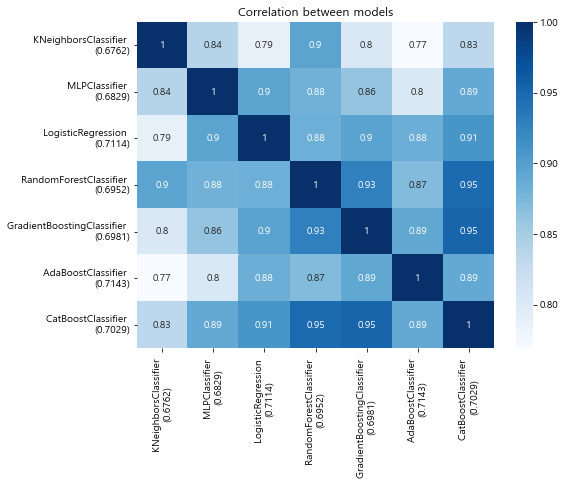

In [59]:
pred_results = []
for name, clf, clf_score in clfs_tuned:
    pred = clf.predict_proba(X_dev)[:,1]
    name = f'{name} \n({clf_score:.4f})'
    pred_results.append(pd.Series(pred, name=name))
ensemble_results = pd.concat(pred_results, axis=1)

# 모형의 예측값 간의 상관관계를 보기 위해 hitmap을 도식한다.
plt.figure(figsize = (8,6))
g = sns.heatmap(ensemble_results.corr(), annot=True, cmap='Blues')
g.set_title("Correlation between models")
plt.show()

*Mean agreement vs. Performance*

In [60]:
# Mean agreement
(ensemble_results.corr().sum()-1)/(ensemble_results.corr().shape[0]-1)

KNeighborsClassifier \n(0.6762)          0.821603
MLPClassifier \n(0.6829)                 0.861926
LogisticRegression \n(0.7114)            0.876479
RandomForestClassifier \n(0.6952)        0.901460
GradientBoostingClassifier \n(0.6981)    0.889363
AdaBoostClassifier \n(0.7143)            0.851758
CatBoostClassifier \n(0.7029)            0.903873
dtype: float64

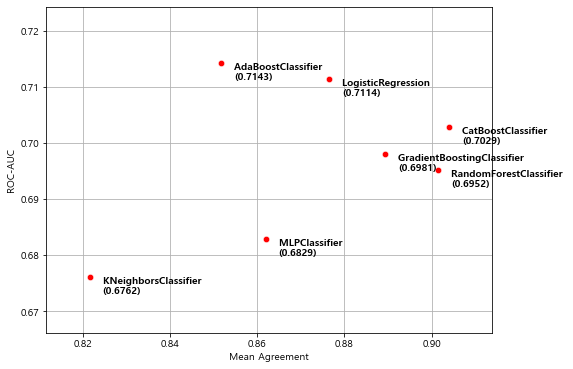

In [61]:
corr = (ensemble_results.corr().sum()-1)/(ensemble_results.corr().shape[0]-1)
names = corr.index
aucs = np.array(corr.index.str[-7:-1]).astype(float)
df = pd.DataFrame({'model': names, 'auc': aucs, 'cor': corr})        

plt.figure(figsize=(8,6))
g = sns.scatterplot(x="cor", y="auc", data=df, s=40, color='red')
for line in range(0, df.shape[0]):
     g.text(df.cor[line]+0.003, df.auc[line]-0.003, 
            df.model[line], horizontalalignment='left', 
            size='medium', color='black', weight='semibold')
        
plt.xlim((df.cor.min()-0.01,df.cor.max()+0.01))
plt.ylim((df.auc.min()-0.01,df.auc.max()+0.01))
plt.xlabel('Mean Agreement')
plt.ylabel('ROC-AUC')
plt.grid()
plt.show()

*Averaging Ensemble*

In [62]:
# Averaging 앙상블에 사용하지 않을 모델은 주석 처리하시오.
selected = [
    'KNeighborsClassifier', 
    'MLPClassifier',
    'LogisticRegression', 
    'RandomForestClassifier', 
    'GradientBoostingClassifier',
    'CatBoostClassifier',
    'AdaBoostClassifier'
]
models_for_ensemble = [clf for clf in clfs_tuned if clf[0] in selected]

In [63]:
# 모델의 모든 조합에 대해서 산술평균, 기하평균, 멱평균 모두 돌려봄.
max_score = 0
for p in tqdm_notebook([-1, 0, 1, 2, 2.56]):  # p==-1:조화평균, p==1:산술평균, p=2 가중평균, p=0:기하평균, 그 외:멱평균(주의:멱평균은 과적합 가능성이 높음)    
    for i in range(2, len(models_for_ensemble)+1):
        for models in combinations(models_for_ensemble, i): # 모든 모델의 조합
            if p == 0:
                pred_mean = gmean([clf.predict_proba(X_dev)[:,1] for name, clf, _ in models], axis=0)
            elif p == -1:
                preds = [clf.predict_proba(X_dev)[:,1] for name, clf, _ in models]
                pred_mean = ((np.sum(np.array(preds)**p, axis=0) / len(models)))**p
              # pred_mean =  len(models) / np.sum(np.array(preds)**p, axis=0)
              # pred_mean = len(models) * np.prod(np.array(preds), axis=0) / np.sum(np.array(preds), axis=0)
            elif p == 2:
                preds = [clf.predict_proba(X_dev)[:,1] for name, clf, _ in models]
                pred_mean = (np.sum(np.array(preds)**p, axis=0)) / (np.sum(np.array(preds), axis=0))
            else:
                preds = [clf.predict_proba(X_dev)[:,1] for name, clf, _ in models]
                pred_mean = (np.sum(np.array(preds)**p, axis=0) / len(models))**(1/p)
            score = roc_auc_score(y_dev, pred_mean)
            if max_score < score:
                best_avg_ensemble = (p, models, score)
                max_score = score

p, models, score = best_avg_ensemble
print('p={}\n{}\n{}'.format(p, '●'.join([clf_name for clf_name, _, _ in models]), score))


p=2.56
LogisticRegression●CatBoostClassifier
0.7705559752760696


In [64]:
# sklearn의 다른 classifier와 호환성을 갖기위해 Custom Classifier인 "AveragingClassifier" 생성

class AveragingClassifier(ClassifierMixin):
    def __init__(self, estimators, p):
        self.estimators = estimators
        self.p = p
    
    def fit(self, X, y):
        return None

    def predict(self, X):
        if self.p == 0:
            pred = gmean([clf.predict(X) for name, clf in self.estimators], axis=0)
        elif p == -1: 
            preds = [clf.predict(X) for name, clf in self.estimators]
            pred = ((np.sum(np.array(preds)**self.p, axis=0) / len(models)))**self.p
        elif p == 2:
            preds = [clf.predict(X) for name, clf in self.estimators]
            pred= (np.sum(np.array(preds)**self.p, axis=0)) / (np.sum(np.array(preds), axis=0))
        else:
            preds = [clf.predict(X) for name, clf in self.estimators]
            pred = (np.sum(np.array(preds)**self.p, axis=0) / len(self.estimators))**(1/self.p)
        return pred
         
    def predict_proba(self, X):
        if self.p == 0:
            prob = gmean([clf.predict_proba(X) for name, clf in self.estimators], axis=0)
        elif p == -1: 
            probs = [clf.predict_proba(X) for name, clf in self.estimators]
            prob = ((np.sum(np.array(probs)**self.p, axis=0) / len(self.estimators)))**self.p
        elif p == 2:
            probs = [clf.predict_proba(X) for name, clf in self.estimators]
            prob= (np.sum(np.array(probs)**self.p, axis=0)) / (np.sum(np.array(probs), axis=0))
        else:
            probs = [clf.predict_proba(X) for name, clf in self.estimators]
            prob = (np.sum(np.array(probs)**self.p, axis=0) / len(self.estimators))**(1/self.p)
        return prob
    
estimators = [(name, clf) for name, clf, _ in models]
avg_clf = AveragingClassifier(estimators, p)
avg_clf.fit(X_train, y_train) 

*Stacking*

서로 다른 계열로 섞거나 부스팅 계열만 섞어서 해보기

boosting 계열
 - AdaBoost
 - GBM(Gradient Boost)
 - XGBoost
 - LightGBM
 - Linear algebraic view of the Boosting
 - Catboost

Neural Net (다른 모델에 비해 이질적)
 - MLP
 
선형모델
 - Logistic Regression
 
분할모델
 - Decission Tree
 - RandomForest

In [65]:
# 2-layer stacking => 3-layer까지 확장할 수 있다.

# Initialize 1st level estimators
# 사용하지 않을 모델은 주석 처리하세요.
selected = [
#    'KNeighborsClassifier', 
#    'MLPClassifier',
    'LogisticRegression', 
#    'RandomForestClassifier', 
    'GradientBoostingClassifier', 
    'CatBoostClassifier',
#    'AdaBoostClassifier'
]

estimators = [(name, clf) for name, clf, _ in clfs_tuned if name in selected]
stk_clf = StackingClassifier(
    estimators=estimators, final_estimator=LogisticRegression(random_state=0), cv=3)

stk_clf.fit(X_train, y_train)
print(roc_auc_score(y_dev, stk_clf.predict_proba(X_dev)[:,1]))  

Learning rate set to 0.015105
0:	learn: 0.6894499	total: 15.8ms	remaining: 15.8s
1:	learn: 0.6860397	total: 24.9ms	remaining: 12.4s
2:	learn: 0.6829960	total: 32.8ms	remaining: 10.9s
3:	learn: 0.6795077	total: 41.4ms	remaining: 10.3s
4:	learn: 0.6761929	total: 49.3ms	remaining: 9.82s
5:	learn: 0.6731517	total: 57.6ms	remaining: 9.55s
6:	learn: 0.6698553	total: 65.6ms	remaining: 9.31s
7:	learn: 0.6669874	total: 73.5ms	remaining: 9.11s
8:	learn: 0.6641664	total: 81.3ms	remaining: 8.95s
9:	learn: 0.6613299	total: 89.3ms	remaining: 8.84s
10:	learn: 0.6583992	total: 97.5ms	remaining: 8.76s
11:	learn: 0.6561353	total: 105ms	remaining: 8.67s
12:	learn: 0.6532510	total: 113ms	remaining: 8.62s
13:	learn: 0.6508751	total: 122ms	remaining: 8.58s
14:	learn: 0.6484603	total: 130ms	remaining: 8.52s
15:	learn: 0.6456082	total: 138ms	remaining: 8.46s
16:	learn: 0.6429003	total: 145ms	remaining: 8.41s
17:	learn: 0.6407694	total: 154ms	remaining: 8.4s
18:	learn: 0.6386673	total: 164ms	remaining: 8.44s
1

168:	learn: 0.5049147	total: 2.82s	remaining: 13.9s
169:	learn: 0.5044002	total: 2.83s	remaining: 13.8s
170:	learn: 0.5039233	total: 2.85s	remaining: 13.8s
171:	learn: 0.5036356	total: 2.86s	remaining: 13.8s
172:	learn: 0.5033080	total: 2.87s	remaining: 13.7s
173:	learn: 0.5030332	total: 2.89s	remaining: 13.7s
174:	learn: 0.5025488	total: 2.9s	remaining: 13.7s
175:	learn: 0.5020081	total: 2.92s	remaining: 13.7s
176:	learn: 0.5015687	total: 2.94s	remaining: 13.7s
177:	learn: 0.5011847	total: 2.95s	remaining: 13.6s
178:	learn: 0.5006910	total: 2.98s	remaining: 13.7s
179:	learn: 0.5001651	total: 2.99s	remaining: 13.6s
180:	learn: 0.4996476	total: 3.01s	remaining: 13.6s
181:	learn: 0.4991403	total: 3.03s	remaining: 13.6s
182:	learn: 0.4986238	total: 3.04s	remaining: 13.6s
183:	learn: 0.4981965	total: 3.05s	remaining: 13.5s
184:	learn: 0.4979497	total: 3.07s	remaining: 13.5s
185:	learn: 0.4975169	total: 3.08s	remaining: 13.5s
186:	learn: 0.4972711	total: 3.1s	remaining: 13.5s
187:	learn: 0.

335:	learn: 0.4493124	total: 5.04s	remaining: 9.96s
336:	learn: 0.4489774	total: 5.05s	remaining: 9.94s
337:	learn: 0.4486956	total: 5.06s	remaining: 9.91s
338:	learn: 0.4483923	total: 5.07s	remaining: 9.88s
339:	learn: 0.4482321	total: 5.08s	remaining: 9.87s
340:	learn: 0.4479554	total: 5.09s	remaining: 9.84s
341:	learn: 0.4476640	total: 5.1s	remaining: 9.82s
342:	learn: 0.4474542	total: 5.11s	remaining: 9.79s
343:	learn: 0.4471149	total: 5.12s	remaining: 9.77s
344:	learn: 0.4469083	total: 5.13s	remaining: 9.74s
345:	learn: 0.4466010	total: 5.14s	remaining: 9.71s
346:	learn: 0.4462772	total: 5.15s	remaining: 9.69s
347:	learn: 0.4460096	total: 5.16s	remaining: 9.66s
348:	learn: 0.4457463	total: 5.16s	remaining: 9.63s
349:	learn: 0.4454238	total: 5.17s	remaining: 9.6s
350:	learn: 0.4451269	total: 5.18s	remaining: 9.58s
351:	learn: 0.4447528	total: 5.19s	remaining: 9.56s
352:	learn: 0.4444826	total: 5.2s	remaining: 9.53s
353:	learn: 0.4443499	total: 5.21s	remaining: 9.51s
354:	learn: 0.4

499:	learn: 0.4057057	total: 6.82s	remaining: 6.82s
500:	learn: 0.4054425	total: 6.83s	remaining: 6.8s
501:	learn: 0.4051581	total: 6.84s	remaining: 6.79s
502:	learn: 0.4049400	total: 6.85s	remaining: 6.77s
503:	learn: 0.4046726	total: 6.87s	remaining: 6.76s
504:	learn: 0.4045350	total: 6.88s	remaining: 6.74s
505:	learn: 0.4043279	total: 6.89s	remaining: 6.72s
506:	learn: 0.4040929	total: 6.9s	remaining: 6.71s
507:	learn: 0.4037266	total: 6.91s	remaining: 6.69s
508:	learn: 0.4034174	total: 6.91s	remaining: 6.67s
509:	learn: 0.4031425	total: 6.92s	remaining: 6.65s
510:	learn: 0.4028163	total: 6.93s	remaining: 6.63s
511:	learn: 0.4025155	total: 6.94s	remaining: 6.62s
512:	learn: 0.4023650	total: 6.95s	remaining: 6.6s
513:	learn: 0.4021733	total: 6.96s	remaining: 6.58s
514:	learn: 0.4020440	total: 6.97s	remaining: 6.56s
515:	learn: 0.4018949	total: 6.97s	remaining: 6.54s
516:	learn: 0.4014921	total: 6.99s	remaining: 6.53s
517:	learn: 0.4010882	total: 7s	remaining: 6.51s
518:	learn: 0.4008

672:	learn: 0.3583074	total: 8.41s	remaining: 4.09s
673:	learn: 0.3580989	total: 8.42s	remaining: 4.07s
674:	learn: 0.3577860	total: 8.43s	remaining: 4.06s
675:	learn: 0.3574145	total: 8.44s	remaining: 4.04s
676:	learn: 0.3571573	total: 8.45s	remaining: 4.03s
677:	learn: 0.3570219	total: 8.45s	remaining: 4.01s
678:	learn: 0.3567672	total: 8.46s	remaining: 4s
679:	learn: 0.3563185	total: 8.47s	remaining: 3.99s
680:	learn: 0.3559798	total: 8.48s	remaining: 3.97s
681:	learn: 0.3557861	total: 8.49s	remaining: 3.96s
682:	learn: 0.3554382	total: 8.5s	remaining: 3.94s
683:	learn: 0.3552265	total: 8.5s	remaining: 3.93s
684:	learn: 0.3549903	total: 8.51s	remaining: 3.91s
685:	learn: 0.3548197	total: 8.52s	remaining: 3.9s
686:	learn: 0.3544197	total: 8.53s	remaining: 3.88s
687:	learn: 0.3541474	total: 8.54s	remaining: 3.87s
688:	learn: 0.3539014	total: 8.54s	remaining: 3.86s
689:	learn: 0.3534492	total: 8.55s	remaining: 3.84s
690:	learn: 0.3532393	total: 8.56s	remaining: 3.83s
691:	learn: 0.3528

839:	learn: 0.3146907	total: 9.83s	remaining: 1.87s
840:	learn: 0.3144989	total: 9.84s	remaining: 1.86s
841:	learn: 0.3142908	total: 9.85s	remaining: 1.85s
842:	learn: 0.3140727	total: 9.86s	remaining: 1.84s
843:	learn: 0.3138318	total: 9.87s	remaining: 1.82s
844:	learn: 0.3135079	total: 9.88s	remaining: 1.81s
845:	learn: 0.3132271	total: 9.89s	remaining: 1.8s
846:	learn: 0.3129789	total: 9.9s	remaining: 1.79s
847:	learn: 0.3126192	total: 9.9s	remaining: 1.77s
848:	learn: 0.3123688	total: 9.91s	remaining: 1.76s
849:	learn: 0.3121269	total: 9.92s	remaining: 1.75s
850:	learn: 0.3118332	total: 9.93s	remaining: 1.74s
851:	learn: 0.3116942	total: 9.94s	remaining: 1.73s
852:	learn: 0.3113864	total: 9.94s	remaining: 1.71s
853:	learn: 0.3110779	total: 9.95s	remaining: 1.7s
854:	learn: 0.3108389	total: 9.96s	remaining: 1.69s
855:	learn: 0.3106220	total: 9.97s	remaining: 1.68s
856:	learn: 0.3104829	total: 9.98s	remaining: 1.66s
857:	learn: 0.3102259	total: 9.98s	remaining: 1.65s
858:	learn: 0.31

Learning rate set to 0.012702
0:	learn: 0.6899908	total: 12.4ms	remaining: 12.4s
1:	learn: 0.6871571	total: 20.2ms	remaining: 10.1s
2:	learn: 0.6844591	total: 27.8ms	remaining: 9.24s
3:	learn: 0.6811492	total: 35.9ms	remaining: 8.94s
4:	learn: 0.6783652	total: 43.7ms	remaining: 8.69s
5:	learn: 0.6756455	total: 51.3ms	remaining: 8.5s
6:	learn: 0.6728709	total: 58.8ms	remaining: 8.34s
7:	learn: 0.6705366	total: 66.1ms	remaining: 8.19s
8:	learn: 0.6679143	total: 73.4ms	remaining: 8.08s
9:	learn: 0.6654387	total: 80.7ms	remaining: 7.99s
10:	learn: 0.6625456	total: 88.2ms	remaining: 7.93s
11:	learn: 0.6602269	total: 95.6ms	remaining: 7.87s
12:	learn: 0.6583365	total: 103ms	remaining: 7.81s
13:	learn: 0.6561202	total: 110ms	remaining: 7.76s
14:	learn: 0.6538384	total: 118ms	remaining: 7.72s
15:	learn: 0.6510987	total: 125ms	remaining: 7.67s
16:	learn: 0.6488958	total: 132ms	remaining: 7.64s
17:	learn: 0.6467576	total: 139ms	remaining: 7.6s
18:	learn: 0.6446724	total: 148ms	remaining: 7.65s
1

176:	learn: 0.4905770	total: 1.43s	remaining: 6.63s
177:	learn: 0.4901420	total: 1.44s	remaining: 6.63s
178:	learn: 0.4897037	total: 1.45s	remaining: 6.63s
179:	learn: 0.4891460	total: 1.46s	remaining: 6.63s
180:	learn: 0.4888478	total: 1.46s	remaining: 6.62s
181:	learn: 0.4883522	total: 1.47s	remaining: 6.61s
182:	learn: 0.4880418	total: 1.48s	remaining: 6.61s
183:	learn: 0.4875112	total: 1.49s	remaining: 6.59s
184:	learn: 0.4872706	total: 1.49s	remaining: 6.59s
185:	learn: 0.4868538	total: 1.5s	remaining: 6.58s
186:	learn: 0.4864170	total: 1.51s	remaining: 6.57s
187:	learn: 0.4859549	total: 1.52s	remaining: 6.56s
188:	learn: 0.4855796	total: 1.53s	remaining: 6.55s
189:	learn: 0.4849042	total: 1.53s	remaining: 6.54s
190:	learn: 0.4844391	total: 1.54s	remaining: 6.54s
191:	learn: 0.4842065	total: 1.55s	remaining: 6.53s
192:	learn: 0.4836939	total: 1.56s	remaining: 6.51s
193:	learn: 0.4831411	total: 1.56s	remaining: 6.5s
194:	learn: 0.4827556	total: 1.57s	remaining: 6.49s
195:	learn: 0.

342:	learn: 0.4270530	total: 3.07s	remaining: 5.88s
343:	learn: 0.4268130	total: 3.08s	remaining: 5.87s
344:	learn: 0.4263972	total: 3.09s	remaining: 5.86s
345:	learn: 0.4259222	total: 3.1s	remaining: 5.85s
346:	learn: 0.4256716	total: 3.1s	remaining: 5.84s
347:	learn: 0.4253152	total: 3.11s	remaining: 5.83s
348:	learn: 0.4250794	total: 3.12s	remaining: 5.82s
349:	learn: 0.4247477	total: 3.13s	remaining: 5.81s
350:	learn: 0.4243557	total: 3.13s	remaining: 5.8s
351:	learn: 0.4241611	total: 3.14s	remaining: 5.79s
352:	learn: 0.4238059	total: 3.15s	remaining: 5.78s
353:	learn: 0.4237384	total: 3.16s	remaining: 5.76s
354:	learn: 0.4234519	total: 3.17s	remaining: 5.76s
355:	learn: 0.4231792	total: 3.18s	remaining: 5.75s
356:	learn: 0.4228331	total: 3.19s	remaining: 5.74s
357:	learn: 0.4225217	total: 3.2s	remaining: 5.73s
358:	learn: 0.4221424	total: 3.21s	remaining: 5.73s
359:	learn: 0.4218968	total: 3.22s	remaining: 5.72s
360:	learn: 0.4215066	total: 3.23s	remaining: 5.71s
361:	learn: 0.42

506:	learn: 0.3789863	total: 4.94s	remaining: 4.8s
507:	learn: 0.3785424	total: 4.95s	remaining: 4.79s
508:	learn: 0.3781504	total: 4.96s	remaining: 4.78s
509:	learn: 0.3778234	total: 4.97s	remaining: 4.77s
510:	learn: 0.3775178	total: 4.97s	remaining: 4.76s
511:	learn: 0.3771009	total: 4.98s	remaining: 4.75s
512:	learn: 0.3768436	total: 4.99s	remaining: 4.74s
513:	learn: 0.3766430	total: 5s	remaining: 4.73s
514:	learn: 0.3763466	total: 5s	remaining: 4.71s
515:	learn: 0.3761896	total: 5.01s	remaining: 4.7s
516:	learn: 0.3757640	total: 5.02s	remaining: 4.69s
517:	learn: 0.3752954	total: 5.03s	remaining: 4.68s
518:	learn: 0.3749158	total: 5.04s	remaining: 4.67s
519:	learn: 0.3745984	total: 5.04s	remaining: 4.66s
520:	learn: 0.3743598	total: 5.05s	remaining: 4.64s
521:	learn: 0.3741621	total: 5.06s	remaining: 4.63s
522:	learn: 0.3737953	total: 5.07s	remaining: 4.62s
523:	learn: 0.3736438	total: 5.07s	remaining: 4.61s
524:	learn: 0.3733930	total: 5.08s	remaining: 4.6s
525:	learn: 0.3731197

674:	learn: 0.3319587	total: 6.36s	remaining: 3.06s
675:	learn: 0.3317518	total: 6.37s	remaining: 3.05s
676:	learn: 0.3313798	total: 6.38s	remaining: 3.04s
677:	learn: 0.3310586	total: 6.39s	remaining: 3.03s
678:	learn: 0.3308382	total: 6.39s	remaining: 3.02s
679:	learn: 0.3305763	total: 6.4s	remaining: 3.01s
680:	learn: 0.3304248	total: 6.41s	remaining: 3s
681:	learn: 0.3301179	total: 6.42s	remaining: 2.99s
682:	learn: 0.3298346	total: 6.42s	remaining: 2.98s
683:	learn: 0.3296449	total: 6.43s	remaining: 2.97s
684:	learn: 0.3293030	total: 6.44s	remaining: 2.96s
685:	learn: 0.3291291	total: 6.45s	remaining: 2.95s
686:	learn: 0.3288977	total: 6.46s	remaining: 2.94s
687:	learn: 0.3287111	total: 6.46s	remaining: 2.93s
688:	learn: 0.3284994	total: 6.47s	remaining: 2.92s
689:	learn: 0.3283691	total: 6.48s	remaining: 2.91s
690:	learn: 0.3281680	total: 6.49s	remaining: 2.9s
691:	learn: 0.3278297	total: 6.49s	remaining: 2.89s
692:	learn: 0.3275685	total: 6.5s	remaining: 2.88s
693:	learn: 0.3273

849:	learn: 0.2846555	total: 7.77s	remaining: 1.37s
850:	learn: 0.2844080	total: 7.78s	remaining: 1.36s
851:	learn: 0.2840281	total: 7.79s	remaining: 1.35s
852:	learn: 0.2837378	total: 7.8s	remaining: 1.34s
853:	learn: 0.2834816	total: 7.81s	remaining: 1.33s
854:	learn: 0.2832181	total: 7.82s	remaining: 1.32s
855:	learn: 0.2829946	total: 7.83s	remaining: 1.32s
856:	learn: 0.2827428	total: 7.83s	remaining: 1.31s
857:	learn: 0.2824561	total: 7.84s	remaining: 1.3s
858:	learn: 0.2822625	total: 7.85s	remaining: 1.29s
859:	learn: 0.2820091	total: 7.86s	remaining: 1.28s
860:	learn: 0.2817136	total: 7.86s	remaining: 1.27s
861:	learn: 0.2814217	total: 7.87s	remaining: 1.26s
862:	learn: 0.2811204	total: 7.88s	remaining: 1.25s
863:	learn: 0.2808951	total: 7.88s	remaining: 1.24s
864:	learn: 0.2806528	total: 7.89s	remaining: 1.23s
865:	learn: 0.2804257	total: 7.9s	remaining: 1.22s
866:	learn: 0.2801875	total: 7.91s	remaining: 1.21s
867:	learn: 0.2799094	total: 7.92s	remaining: 1.2s
868:	learn: 0.27

22:	learn: 0.6307679	total: 182ms	remaining: 7.72s
23:	learn: 0.6287635	total: 191ms	remaining: 7.78s
24:	learn: 0.6267082	total: 201ms	remaining: 7.83s
25:	learn: 0.6242131	total: 210ms	remaining: 7.86s
26:	learn: 0.6223567	total: 217ms	remaining: 7.83s
27:	learn: 0.6201150	total: 225ms	remaining: 7.81s
28:	learn: 0.6181833	total: 232ms	remaining: 7.78s
29:	learn: 0.6167344	total: 240ms	remaining: 7.76s
30:	learn: 0.6152470	total: 248ms	remaining: 7.75s
31:	learn: 0.6133413	total: 256ms	remaining: 7.74s
32:	learn: 0.6112598	total: 265ms	remaining: 7.76s
33:	learn: 0.6096170	total: 273ms	remaining: 7.75s
34:	learn: 0.6079399	total: 280ms	remaining: 7.72s
35:	learn: 0.6061942	total: 288ms	remaining: 7.71s
36:	learn: 0.6045374	total: 295ms	remaining: 7.69s
37:	learn: 0.6025986	total: 303ms	remaining: 7.67s
38:	learn: 0.6011550	total: 310ms	remaining: 7.65s
39:	learn: 0.5995048	total: 318ms	remaining: 7.63s
40:	learn: 0.5974453	total: 326ms	remaining: 7.62s
41:	learn: 0.5959596	total: 333

184:	learn: 0.4848161	total: 2.27s	remaining: 9.99s
185:	learn: 0.4842517	total: 2.33s	remaining: 10.2s
186:	learn: 0.4836344	total: 2.38s	remaining: 10.4s
187:	learn: 0.4833397	total: 2.48s	remaining: 10.7s
188:	learn: 0.4826676	total: 2.51s	remaining: 10.8s
189:	learn: 0.4822676	total: 2.55s	remaining: 10.9s
190:	learn: 0.4816739	total: 2.58s	remaining: 10.9s
191:	learn: 0.4810960	total: 2.59s	remaining: 10.9s
192:	learn: 0.4804829	total: 2.61s	remaining: 10.9s
193:	learn: 0.4799138	total: 2.62s	remaining: 10.9s
194:	learn: 0.4791113	total: 2.63s	remaining: 10.9s
195:	learn: 0.4786706	total: 2.65s	remaining: 10.9s
196:	learn: 0.4782523	total: 2.66s	remaining: 10.8s
197:	learn: 0.4775141	total: 2.68s	remaining: 10.8s
198:	learn: 0.4771095	total: 2.69s	remaining: 10.8s
199:	learn: 0.4766741	total: 2.7s	remaining: 10.8s
200:	learn: 0.4761544	total: 2.71s	remaining: 10.8s
201:	learn: 0.4756730	total: 2.72s	remaining: 10.7s
202:	learn: 0.4752941	total: 2.73s	remaining: 10.7s
203:	learn: 0

345:	learn: 0.4242133	total: 3.91s	remaining: 7.39s
346:	learn: 0.4237403	total: 3.92s	remaining: 7.37s
347:	learn: 0.4233452	total: 3.93s	remaining: 7.36s
348:	learn: 0.4230996	total: 3.94s	remaining: 7.34s
349:	learn: 0.4226252	total: 3.94s	remaining: 7.33s
350:	learn: 0.4221693	total: 3.95s	remaining: 7.31s
351:	learn: 0.4218337	total: 3.96s	remaining: 7.29s
352:	learn: 0.4213110	total: 3.97s	remaining: 7.27s
353:	learn: 0.4208997	total: 3.98s	remaining: 7.25s
354:	learn: 0.4205153	total: 3.98s	remaining: 7.24s
355:	learn: 0.4202286	total: 3.99s	remaining: 7.22s
356:	learn: 0.4200168	total: 4s	remaining: 7.2s
357:	learn: 0.4197369	total: 4s	remaining: 7.18s
358:	learn: 0.4194493	total: 4.01s	remaining: 7.16s
359:	learn: 0.4192348	total: 4.02s	remaining: 7.15s
360:	learn: 0.4189120	total: 4.03s	remaining: 7.13s
361:	learn: 0.4185222	total: 4.04s	remaining: 7.11s
362:	learn: 0.4182787	total: 4.04s	remaining: 7.09s
363:	learn: 0.4180589	total: 4.05s	remaining: 7.08s
364:	learn: 0.41785

520:	learn: 0.3718643	total: 5.32s	remaining: 4.89s
521:	learn: 0.3715021	total: 5.33s	remaining: 4.88s
522:	learn: 0.3712283	total: 5.34s	remaining: 4.87s
523:	learn: 0.3709273	total: 5.35s	remaining: 4.86s
524:	learn: 0.3705717	total: 5.36s	remaining: 4.85s
525:	learn: 0.3703141	total: 5.37s	remaining: 4.83s
526:	learn: 0.3702371	total: 5.37s	remaining: 4.82s
527:	learn: 0.3700476	total: 5.38s	remaining: 4.81s
528:	learn: 0.3698153	total: 5.39s	remaining: 4.8s
529:	learn: 0.3694099	total: 5.4s	remaining: 4.79s
530:	learn: 0.3691251	total: 5.4s	remaining: 4.77s
531:	learn: 0.3686655	total: 5.41s	remaining: 4.76s
532:	learn: 0.3682642	total: 5.42s	remaining: 4.75s
533:	learn: 0.3680715	total: 5.43s	remaining: 4.74s
534:	learn: 0.3677595	total: 5.43s	remaining: 4.72s
535:	learn: 0.3675251	total: 5.44s	remaining: 4.71s
536:	learn: 0.3671901	total: 5.45s	remaining: 4.7s
537:	learn: 0.3669394	total: 5.46s	remaining: 4.68s
538:	learn: 0.3664874	total: 5.46s	remaining: 4.67s
539:	learn: 0.36

696:	learn: 0.3220841	total: 6.74s	remaining: 2.93s
697:	learn: 0.3218299	total: 6.75s	remaining: 2.92s
698:	learn: 0.3217272	total: 6.76s	remaining: 2.91s
699:	learn: 0.3214036	total: 6.77s	remaining: 2.9s
700:	learn: 0.3211371	total: 6.78s	remaining: 2.89s
701:	learn: 0.3209961	total: 6.79s	remaining: 2.88s
702:	learn: 0.3206458	total: 6.79s	remaining: 2.87s
703:	learn: 0.3203584	total: 6.8s	remaining: 2.86s
704:	learn: 0.3201324	total: 6.81s	remaining: 2.85s
705:	learn: 0.3197640	total: 6.82s	remaining: 2.84s
706:	learn: 0.3194601	total: 6.82s	remaining: 2.83s
707:	learn: 0.3191485	total: 6.83s	remaining: 2.82s
708:	learn: 0.3188190	total: 6.84s	remaining: 2.81s
709:	learn: 0.3184087	total: 6.84s	remaining: 2.8s
710:	learn: 0.3181629	total: 6.85s	remaining: 2.79s
711:	learn: 0.3177289	total: 6.86s	remaining: 2.77s
712:	learn: 0.3174904	total: 6.87s	remaining: 2.76s
713:	learn: 0.3172191	total: 6.88s	remaining: 2.75s
714:	learn: 0.3169487	total: 6.88s	remaining: 2.74s
715:	learn: 0.3

873:	learn: 0.2737891	total: 8.17s	remaining: 1.18s
874:	learn: 0.2735956	total: 8.18s	remaining: 1.17s
875:	learn: 0.2733382	total: 8.19s	remaining: 1.16s
876:	learn: 0.2729561	total: 8.2s	remaining: 1.15s
877:	learn: 0.2726991	total: 8.21s	remaining: 1.14s
878:	learn: 0.2725026	total: 8.21s	remaining: 1.13s
879:	learn: 0.2722571	total: 8.22s	remaining: 1.12s
880:	learn: 0.2719671	total: 8.23s	remaining: 1.11s
881:	learn: 0.2716570	total: 8.24s	remaining: 1.1s
882:	learn: 0.2714069	total: 8.25s	remaining: 1.09s
883:	learn: 0.2712294	total: 8.25s	remaining: 1.08s
884:	learn: 0.2710382	total: 8.26s	remaining: 1.07s
885:	learn: 0.2707866	total: 8.27s	remaining: 1.06s
886:	learn: 0.2705454	total: 8.28s	remaining: 1.05s
887:	learn: 0.2704133	total: 8.28s	remaining: 1.04s
888:	learn: 0.2702887	total: 8.29s	remaining: 1.03s
889:	learn: 0.2701442	total: 8.3s	remaining: 1.02s
890:	learn: 0.2699768	total: 8.31s	remaining: 1.02s
891:	learn: 0.2696390	total: 8.31s	remaining: 1.01s
892:	learn: 0.2

42:	learn: 0.6066561	total: 347ms	remaining: 7.72s
43:	learn: 0.6055479	total: 356ms	remaining: 7.74s
44:	learn: 0.6042555	total: 366ms	remaining: 7.76s
45:	learn: 0.6024553	total: 375ms	remaining: 7.77s
46:	learn: 0.6012265	total: 382ms	remaining: 7.75s
47:	learn: 0.6000722	total: 390ms	remaining: 7.74s
48:	learn: 0.5988271	total: 398ms	remaining: 7.72s
49:	learn: 0.5976651	total: 405ms	remaining: 7.69s
50:	learn: 0.5968749	total: 412ms	remaining: 7.67s
51:	learn: 0.5955457	total: 420ms	remaining: 7.65s
52:	learn: 0.5941631	total: 427ms	remaining: 7.63s
53:	learn: 0.5928445	total: 434ms	remaining: 7.61s
54:	learn: 0.5916723	total: 442ms	remaining: 7.59s
55:	learn: 0.5904471	total: 449ms	remaining: 7.57s
56:	learn: 0.5891975	total: 457ms	remaining: 7.55s
57:	learn: 0.5880905	total: 464ms	remaining: 7.54s
58:	learn: 0.5868851	total: 472ms	remaining: 7.52s
59:	learn: 0.5861405	total: 479ms	remaining: 7.5s
60:	learn: 0.5850157	total: 487ms	remaining: 7.49s
61:	learn: 0.5837901	total: 495m

215:	learn: 0.4872383	total: 1.77s	remaining: 6.43s
216:	learn: 0.4868857	total: 1.78s	remaining: 6.42s
217:	learn: 0.4864552	total: 1.8s	remaining: 6.45s
218:	learn: 0.4862326	total: 1.82s	remaining: 6.48s
219:	learn: 0.4859003	total: 1.83s	remaining: 6.49s
220:	learn: 0.4855911	total: 1.84s	remaining: 6.49s
221:	learn: 0.4849988	total: 1.85s	remaining: 6.48s
222:	learn: 0.4845902	total: 1.85s	remaining: 6.47s
223:	learn: 0.4842345	total: 1.86s	remaining: 6.46s
224:	learn: 0.4839252	total: 1.87s	remaining: 6.44s
225:	learn: 0.4834496	total: 1.88s	remaining: 6.43s
226:	learn: 0.4831435	total: 1.89s	remaining: 6.42s
227:	learn: 0.4828372	total: 1.89s	remaining: 6.41s
228:	learn: 0.4824372	total: 1.9s	remaining: 6.4s
229:	learn: 0.4819941	total: 1.91s	remaining: 6.39s
230:	learn: 0.4816210	total: 1.92s	remaining: 6.38s
231:	learn: 0.4813481	total: 1.92s	remaining: 6.37s
232:	learn: 0.4810098	total: 1.93s	remaining: 6.36s
233:	learn: 0.4805117	total: 1.94s	remaining: 6.34s
234:	learn: 0.4

387:	learn: 0.4252747	total: 3.19s	remaining: 5.02s
388:	learn: 0.4249098	total: 3.19s	remaining: 5.02s
389:	learn: 0.4245289	total: 3.2s	remaining: 5.01s
390:	learn: 0.4241807	total: 3.21s	remaining: 5.01s
391:	learn: 0.4239099	total: 3.22s	remaining: 5s
392:	learn: 0.4236555	total: 3.23s	remaining: 4.99s
393:	learn: 0.4234586	total: 3.24s	remaining: 4.98s
394:	learn: 0.4231486	total: 3.24s	remaining: 4.97s
395:	learn: 0.4228860	total: 3.25s	remaining: 4.96s
396:	learn: 0.4226421	total: 3.26s	remaining: 4.95s
397:	learn: 0.4225083	total: 3.27s	remaining: 4.94s
398:	learn: 0.4222599	total: 3.27s	remaining: 4.93s
399:	learn: 0.4219796	total: 3.28s	remaining: 4.92s
400:	learn: 0.4216130	total: 3.29s	remaining: 4.91s
401:	learn: 0.4214099	total: 3.3s	remaining: 4.9s
402:	learn: 0.4211899	total: 3.3s	remaining: 4.89s
403:	learn: 0.4207995	total: 3.31s	remaining: 4.88s
404:	learn: 0.4204835	total: 3.32s	remaining: 4.88s
405:	learn: 0.4201978	total: 3.33s	remaining: 4.87s
406:	learn: 0.42001

563:	learn: 0.3742726	total: 4.61s	remaining: 3.56s
564:	learn: 0.3740109	total: 4.62s	remaining: 3.55s
565:	learn: 0.3737336	total: 4.63s	remaining: 3.55s
566:	learn: 0.3733696	total: 4.63s	remaining: 3.54s
567:	learn: 0.3729691	total: 4.64s	remaining: 3.53s
568:	learn: 0.3727815	total: 4.65s	remaining: 3.52s
569:	learn: 0.3726020	total: 4.66s	remaining: 3.51s
570:	learn: 0.3723274	total: 4.67s	remaining: 3.5s
571:	learn: 0.3720765	total: 4.67s	remaining: 3.5s
572:	learn: 0.3719295	total: 4.68s	remaining: 3.49s
573:	learn: 0.3717167	total: 4.69s	remaining: 3.48s
574:	learn: 0.3714401	total: 4.7s	remaining: 3.47s
575:	learn: 0.3711581	total: 4.7s	remaining: 3.46s
576:	learn: 0.3708543	total: 4.71s	remaining: 3.45s
577:	learn: 0.3703682	total: 4.72s	remaining: 3.44s
578:	learn: 0.3701197	total: 4.72s	remaining: 3.44s
579:	learn: 0.3698539	total: 4.73s	remaining: 3.43s
580:	learn: 0.3695847	total: 4.74s	remaining: 3.42s
581:	learn: 0.3694046	total: 4.75s	remaining: 3.41s
582:	learn: 0.36

739:	learn: 0.3239422	total: 6.03s	remaining: 2.12s
740:	learn: 0.3236690	total: 6.04s	remaining: 2.11s
741:	learn: 0.3233107	total: 6.04s	remaining: 2.1s
742:	learn: 0.3229948	total: 6.05s	remaining: 2.09s
743:	learn: 0.3227844	total: 6.06s	remaining: 2.08s
744:	learn: 0.3224602	total: 6.07s	remaining: 2.08s
745:	learn: 0.3221754	total: 6.08s	remaining: 2.07s
746:	learn: 0.3217459	total: 6.08s	remaining: 2.06s
747:	learn: 0.3216686	total: 6.09s	remaining: 2.05s
748:	learn: 0.3214549	total: 6.1s	remaining: 2.04s
749:	learn: 0.3210326	total: 6.11s	remaining: 2.04s
750:	learn: 0.3208060	total: 6.11s	remaining: 2.03s
751:	learn: 0.3203935	total: 6.12s	remaining: 2.02s
752:	learn: 0.3200715	total: 6.13s	remaining: 2.01s
753:	learn: 0.3198764	total: 6.14s	remaining: 2s
754:	learn: 0.3195724	total: 6.14s	remaining: 1.99s
755:	learn: 0.3193697	total: 6.15s	remaining: 1.99s
756:	learn: 0.3190638	total: 6.16s	remaining: 1.98s
757:	learn: 0.3187216	total: 6.17s	remaining: 1.97s
758:	learn: 0.318

913:	learn: 0.2763660	total: 7.44s	remaining: 700ms
914:	learn: 0.2759366	total: 7.45s	remaining: 692ms
915:	learn: 0.2757207	total: 7.46s	remaining: 684ms
916:	learn: 0.2755438	total: 7.47s	remaining: 676ms
917:	learn: 0.2753050	total: 7.48s	remaining: 668ms
918:	learn: 0.2750857	total: 7.49s	remaining: 660ms
919:	learn: 0.2748816	total: 7.5s	remaining: 652ms
920:	learn: 0.2746068	total: 7.51s	remaining: 644ms
921:	learn: 0.2743677	total: 7.51s	remaining: 636ms
922:	learn: 0.2740499	total: 7.52s	remaining: 627ms
923:	learn: 0.2737082	total: 7.53s	remaining: 619ms
924:	learn: 0.2735140	total: 7.54s	remaining: 611ms
925:	learn: 0.2731908	total: 7.54s	remaining: 603ms
926:	learn: 0.2729514	total: 7.55s	remaining: 595ms
927:	learn: 0.2727180	total: 7.56s	remaining: 586ms
928:	learn: 0.2724755	total: 7.57s	remaining: 578ms
929:	learn: 0.2721719	total: 7.57s	remaining: 570ms
930:	learn: 0.2718707	total: 7.58s	remaining: 562ms
931:	learn: 0.2716262	total: 7.59s	remaining: 554ms
932:	learn: 0

### 6. Deployment

In [66]:
# Averaging ensemble로 예측한 submission: 
pd.DataFrame({'cust_id': test_id, 'gender': avg_clf.predict_proba(test)[:,1]}).to_csv('submission_avg.csv', index=False)

# Stacking ensemble로 예측한 submission: 
pd.DataFrame({'cust_id': test_id, 'gender': stk_clf.predict_proba(test)[:,1]}).to_csv('submission_stk.csv', index=False)

<font color="#CC3D3D"><p>
# End

결측치(숫자형/범주형)	  이상치처리	     스케일링	          인코딩	      피쳐셀렉션	       앙상블	   스태킹	  앙상블 조합  
mean / most frequent	     5% ~ 95%	PowerTransformer	OneHotEncoding	LogisticRegression	0.743921	0.74261 	MLP●GBC  

constant / most frequent	 5% ~ 95%	PowerTransformer	OneHotEncoding	LogisticRegression	0.753637	0.751183	MLP●GBC●LR

median / most frequent	     5% ~ 95%	PowerTransformer	OneHotEncoding	LogisticRegression	0.743823	0.741772	MLP●RF

constant / most frequent	 5% ~ 95%	MinMax	            OneHotEncoding	LogisticRegression	0.749018	0.744994	MLP●GBC

mean / most frequent	     5% ~ 95%	PowerTransformer	OneHotEncoding	LogisticRegression	0.743921	0.74261	    LR●GBC

constant / most frequent	 5% ~ 95%	PowerTransformer	MeanEncoding	LogisticRegression	0.765999	0.764997	LR●GBC

constant / most frequent	 5% ~ 95%	StandardScaler	    MeanEncoding	LogisticRegression	0.772125	0.766308	LR●GBC

constant / most frequent	 5% ~ 95%	PowerTransformer	MeanEncoding	LogisticRegression	0.765882	0.765674	LR●GBC

-> Cat, Ada 추가							

KNN / most frequent	         5% ~ 95%	PowerTransformer	MeanEncoding	LogisticRegression	0.763791	0.760045	LR●Ada●Cat

constant / most frequent	 5% ~ 95%	StandardScaler	    MeanEncoding	LogisticRegression	0.763791	0.760045	LR●Ada●Cat

constant / most frequent	   IQR	    PowerTransformer	MeanEncoding	LogisticRegression	0.76924	    0.767514	LR●Ada●Cat●GBC


constant / most frequent       IQR	     MinMax	            OneHotEncoding	GradientBoosting	0.74937	    0.748893	MLP●GBC●Cat

constant / most frequent	   IQR	     MinMax	            MeanEncoding	GradientBoosting	0.771248	0.767549	LR●Cat●MLP●Ada●GBC

constant / most frequent	   IQR	     Standard	        OneHotEncoding	GradientBoosting	0.752964	0.750846	LR●GBC

constant / most frequent	   IQR	     Standard	        MeanEncoding	GradientBoosting	0.771796	0.76832	    LR●GBC●Cat●Ada
- staking 조합
- GradientBoosting + CatBoost + AdaBoost = 0.764367
- Knn + Logistic + RandomForest + AdaBoost = 0.763329
- Logistic + Knn + Ada = 0.761392
- Logistic + GradientBoosting + Catboost + Ada = 0.769651

constant / most frequent	 5% ~ 95%	MinMax	            OneHotEncoding	GradientBoosting	0.748814	0.747108	LR●GBC●Cat

constant / most frequent	 5% ~ 95%	MinMax	            MeanEncoding	GradientBoosting	0.770649	0.766328	LR●Cat

constant / most frequent	 5% ~ 95%	Standard	        OneHotEncoding	GradientBoosting	0.751374	0.748846	MLP●GBC●Cat

constant / most frequent	 5% ~ 95%	Standard	        MeanEncoding	GradientBoosting	0.770078	0.766958	LR●Ada●Cat
							
constant / most frequent	 5% ~ 95%	PowerTransformer	OneHotEncoding	GradientBoosting	0.751151	0.749073	MLP●LR●GBC●Cat

constant / most frequent	 5% ~ 95%	PowerTransformer	MeanEncoding	GradientBoosting	0.768622	0.767369	LR●Cat

constant / most frequent	 5% ~ 95%	MaxAbs	            OneHotEncoding	GradientBoosting	0.750529	0.747816	MLP●GBC●Cat

constant / most frequent	 5% ~ 95%	MaxAbs	            MeanEncoding	GradientBoosting	0.770387	0.765251	LR●Cat

constant / most frequent	   IQR	    PowerTransformer	OneHotEncoding	GradientBoosting	0.752024	0.750188	MLP●GBC●Cat

constant / most frequent	   IQR	    PowerTransformer	MeanEncoding	GradientBoosting	0.772039	0.76868	    LR●Ada●Cat

constant / most frequent	   IQR	    MaxAbs	            OneHotEncoding	GradientBoosting	0.749856	0.749445	MLP●LR●GBC●Cat

constant / most frequent	   IQR	    MaxAbs	            MeanEncoding	GradientBoosting	0.771268	0.767432	LR●GBC●Ada●Cat

median / most frequent	       IQR   	PowerTransformer	MeanEncoding	GradientBoosting	0.771045	0.767991	LR●Ada●Cat	
- staking 조합
- KNN + LR + Cat + Ada = 0.769561
- LG + KNN + Ada + Rf = 0.765839
- GDB + Cat + Ada = 0.762523
- LG + GDB + Cat = 0.769655

mean / most frequent	       IQR	    PowerTransformer	MeanEncoding	GradientBoosting	0.770047    0.769726		LR●GBC●Ada
- staking 조합
- GDB + Cat + Ada = 0.762523